# Load the data and libraries

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, EngFormatter, PercentFormatter
import plotly.express as px
from siuba.dply.forcats import fct_lump
from sklearn.preprocessing import LabelEncoder

plt.rcParams['figure.figsize'] = (11,7)
pd.set_option('display.max_columns',20)

In [3]:
students = pd.read_csv("../data/students_processed_cats.csv")

In [4]:
students.head()

,marital_status,application_mode,application_order,course,daytime/evening_attendance,previous_qualification,nationality,mother's_qualification,father's_qualification,mother's_occupation,...,curricular_units_2nd_sem_(credited),curricular_units_2nd_sem_(enrolled),curricular_units_2nd_sem_(evaluations),curricular_units_2nd_sem_(approved),curricular_units_2nd_sem_(grade),curricular_units_2nd_sem_(without_evaluations),unemployment_rate,inflation_rate,gdp,target
0,Single,2nd phase - general contingent,5,Animation and Multimedia Design,daytime,Secondary education,Portuguese,General commerce course,Other - 11th Year of Schooling,"Personal Services, Security and Safety Workers...",...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,Single,International student (bachelor),1,Tourism,daytime,Secondary education,Portuguese,Secondary Education - 12th Year of Schooling o...,Higher Education - Degree,Intermediate Level Technicians and Professions,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,Single,1st phase - general contingent,5,Communication Design,daytime,Secondary education,Portuguese,General Course of Administration and Commerce,Basic education 1st cycle (4th/5th year),Unskilled Workers,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,Single,2nd phase - general contingent,2,Journalism and Communication,daytime,Secondary education,Portuguese,Supplementary Accounting and Administration,Basic education 1st cycle (4th/5th year),"Personal Services, Security and Safety Workers...",...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,Married,Over 23 years old,1,Social Service (evening attendance),evening,Secondary education,Portuguese,General Course of Administration and Commerce,Basic Education 2nd Cycle (6th/7th/8th Year),Unskilled Workers,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# Target variable analysis

In [5]:
students.target.unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

Transform this column to order categorical

In [6]:
target_order = ["Dropout", "Enrolled", "Graduate"]
target_palette = {"Graduate":"#4ECDC4", "Enrolled": "#FFE66D", "Dropout":"#FF6B6B"}
students["target"] = students['target'].astype("category").cat.reorder_categories(target_order)

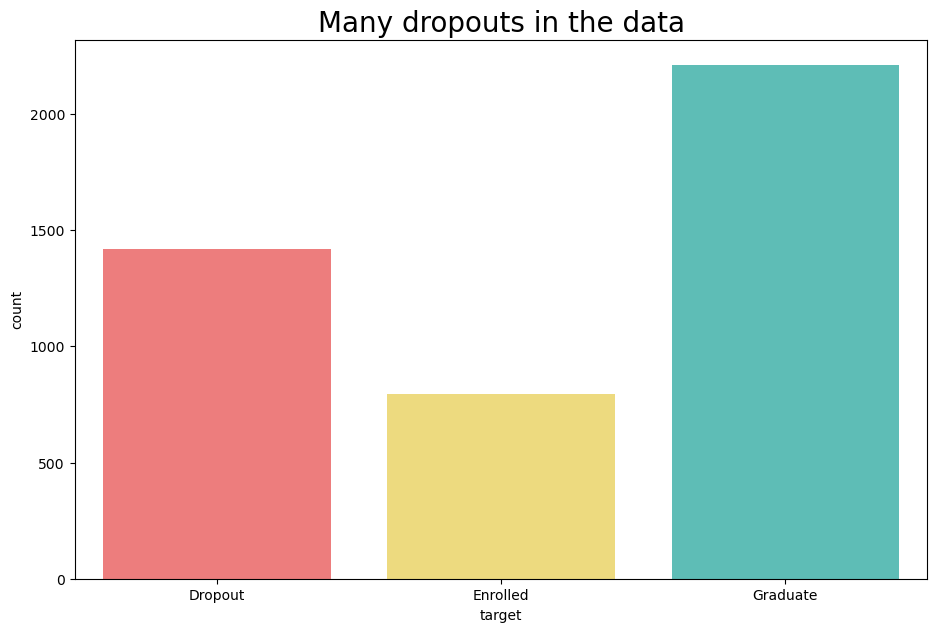

In [7]:
sns.countplot(students, x = "target", palette=target_palette)
plt.title("Many dropouts in the data", fontsize = 20)
plt.show()

In [10]:
students.target.value_counts(sort = False, normalize=True)

Dropout     0.321203
Enrolled    0.179476
Graduate    0.499322
Name: target, dtype: float64

Only 50% of the initial students graduates on time, 32% leave the course and 18% continue studying and the end of the regular course. Almost 1/3 of the total dropout the school.

# Univariate analysis (relation with target)

In [11]:
def plot_proportions(data, var, size = (13,6)):
    var_title = var.replace("_"," ").title()
    data_filter = data.groupby(var, as_index = False)["target"].value_counts()
    data_filter["proportion"] = data_filter.groupby(var)["count"].transform(lambda x: x / sum(x))
    y_order = data_filter.query("target == 'Graduate'").sort_values("proportion", ascending = False)[var].values
    return (
       so.Plot(data_filter, y = var, color = "target")
       .pair(x = ["proportion", "count"])
       .layout(size = size, engine = "tight")
       .add(so.Bar(), so.Dodge())
       .scale(color=so.Nominal(order=target_order[::-1], values = target_palette),
              y = so.Nominal(order = y_order),
              x0 = so.Continuous().label(like = "{x:.0%}"))
       .label(y = var_title,
              x0 = lambda x: x.title(),
              x1 = lambda x: x.title(),
              color = "Target")
       .theme({**axes_style("white")})
    )

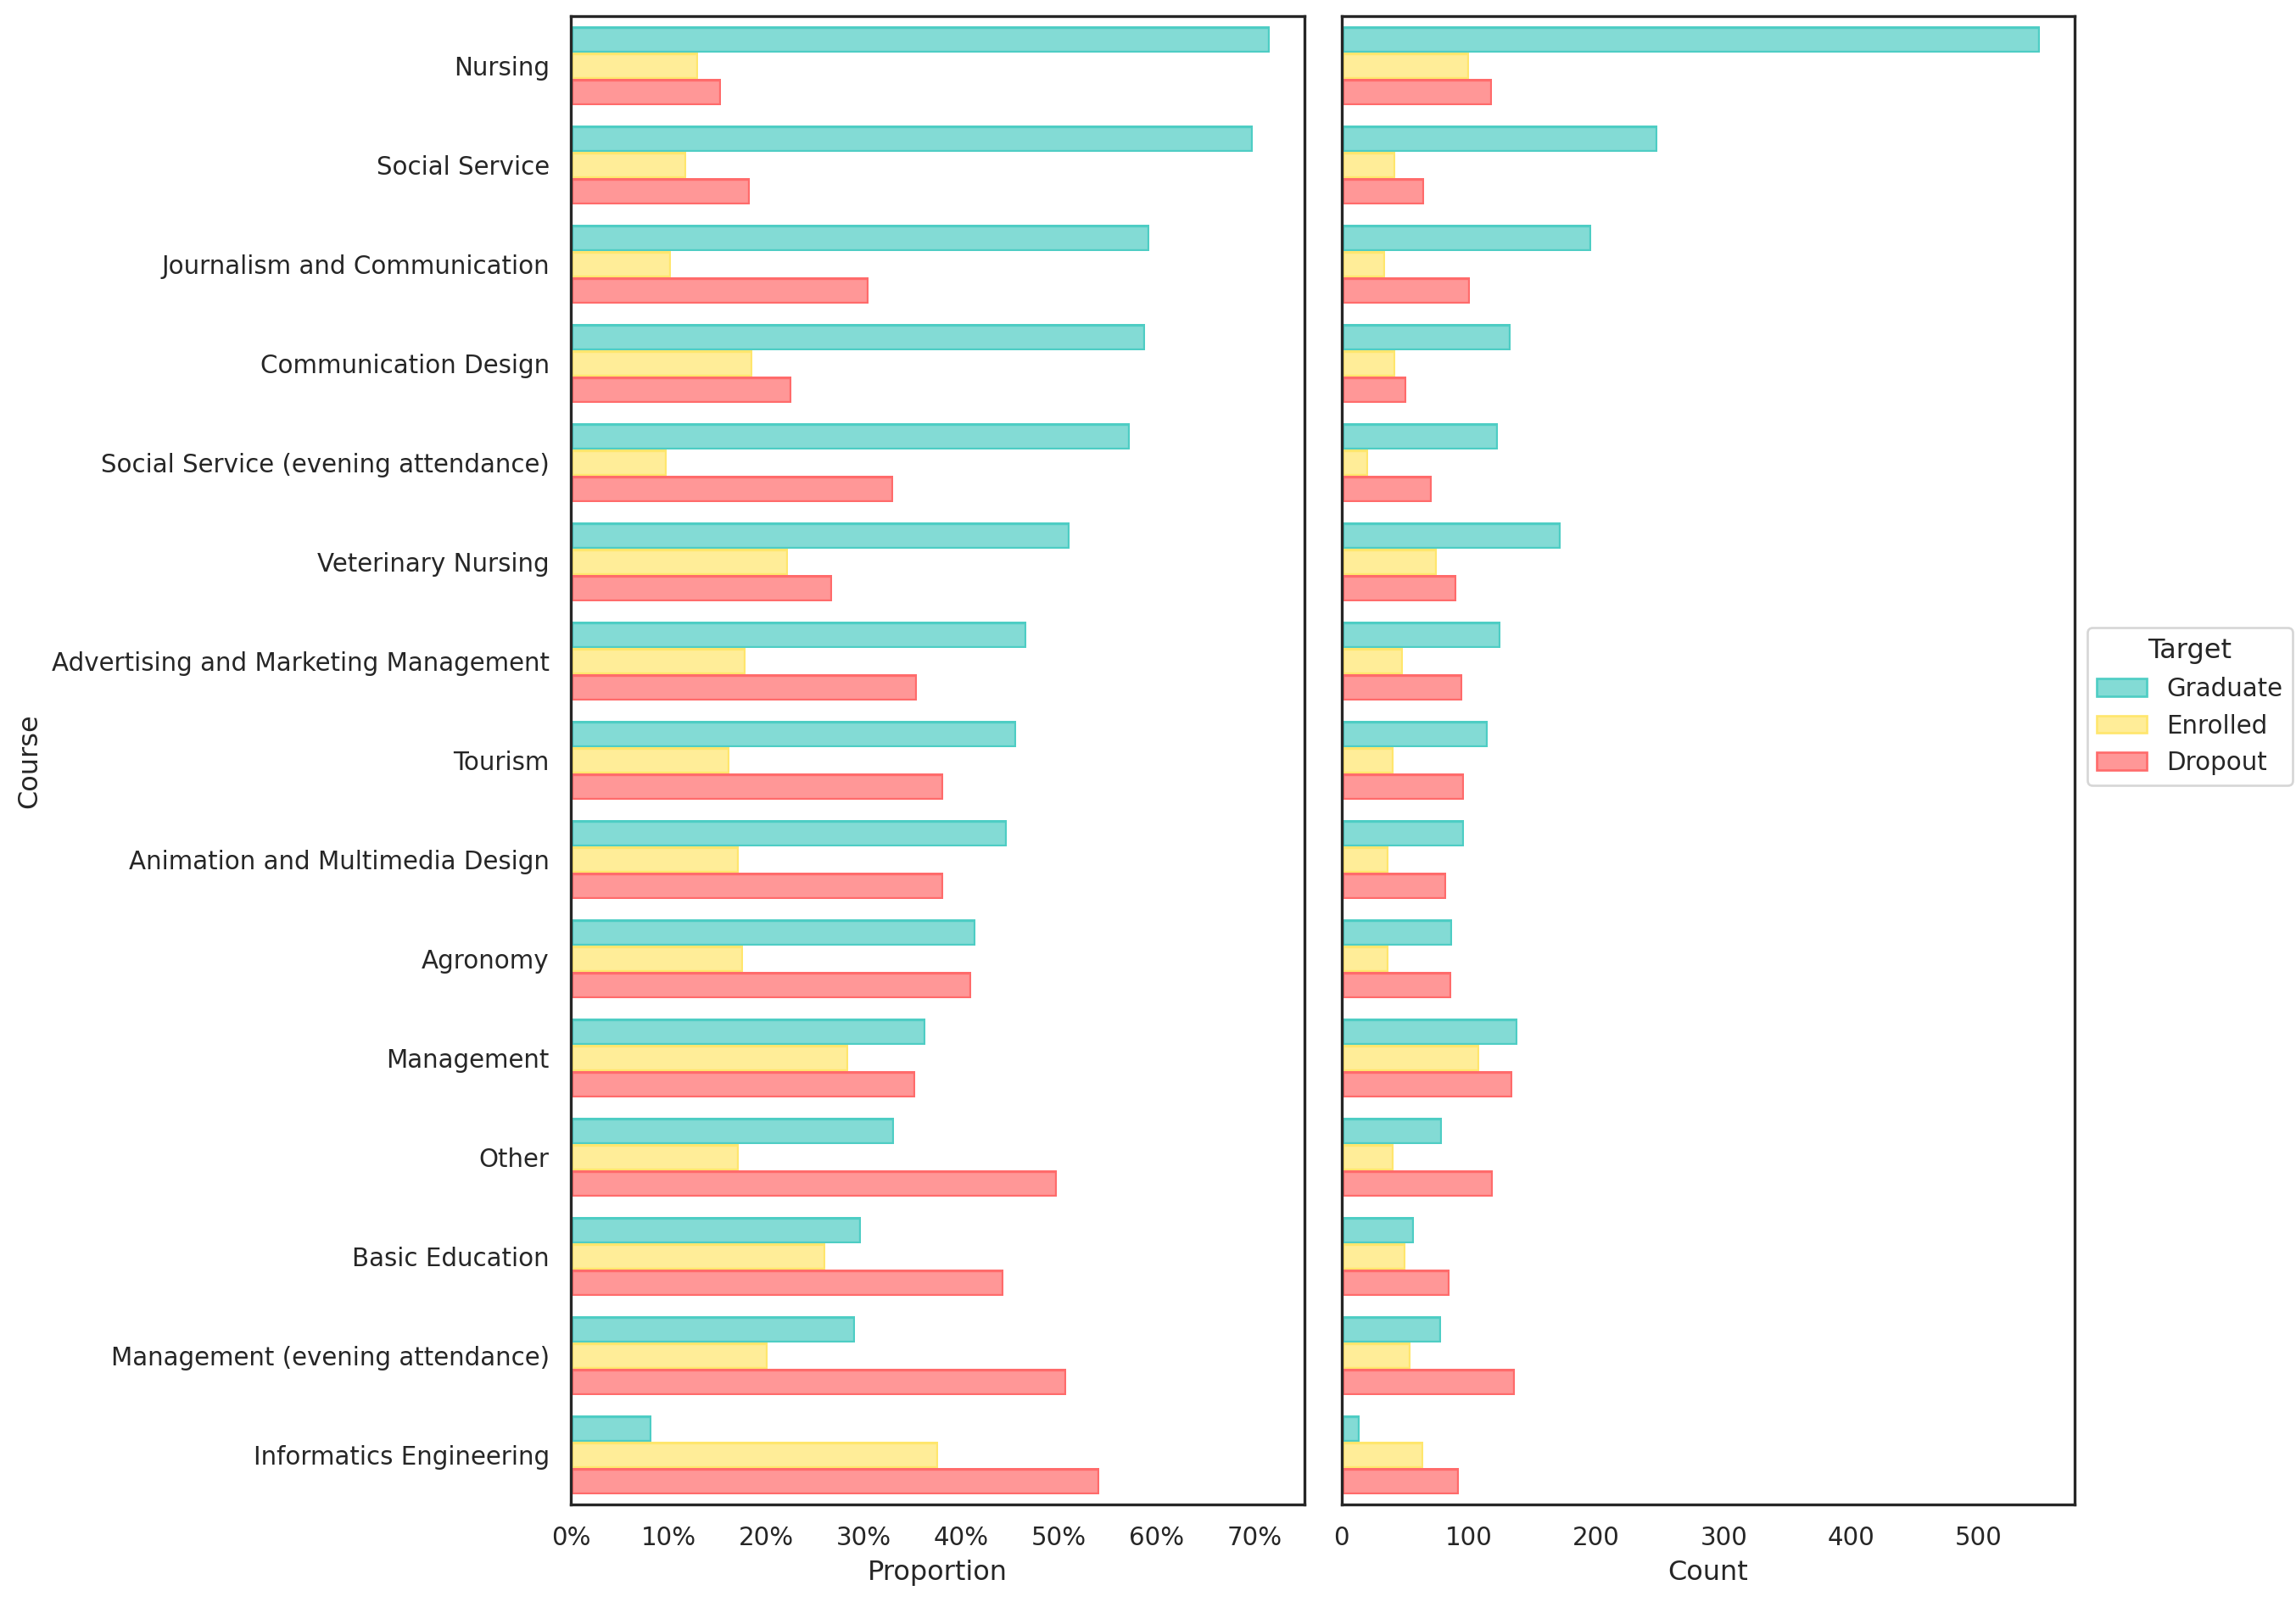

In [12]:
students.assign(course = lambda x: fct_lump(x.course, 14)).pipe(plot_proportions, "course", (13,10))

The course have a strong correlation with graduation rate. In the nursing course, 70% of the total students graduate, while less than 10% graduates in informatics engineering.

Also there are only 2 courses in the evening (Management and Social service), in both cases the dropout rate is higher in the evening than in the morning

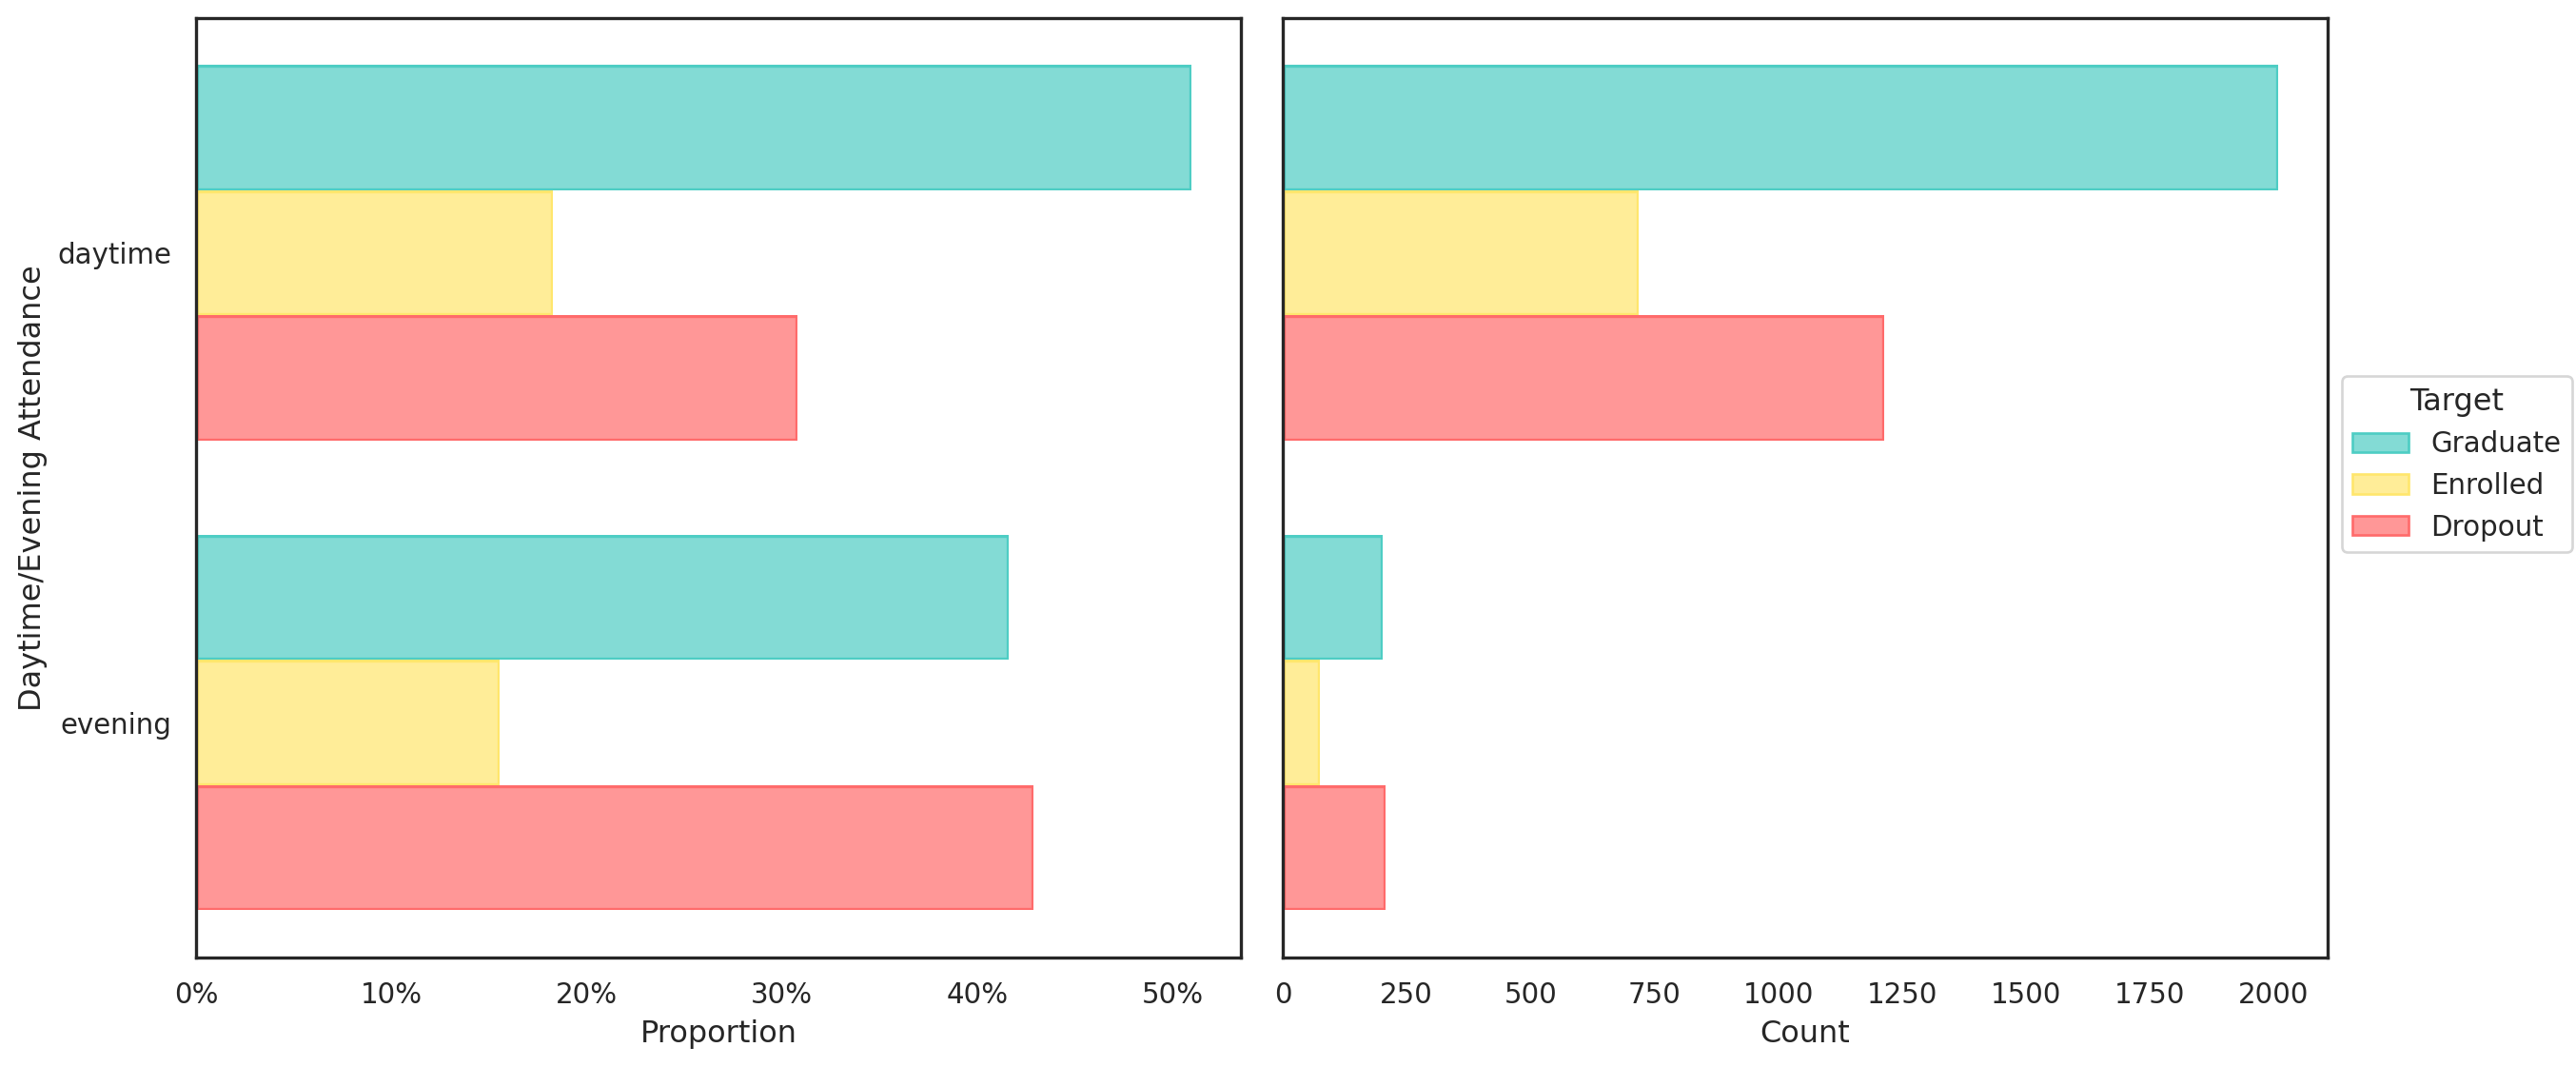

In [13]:
students.pipe(plot_proportions, "daytime/evening_attendance")

Daytime students are more likely to graduate, the majority of the evening students dropout (more than 40%)

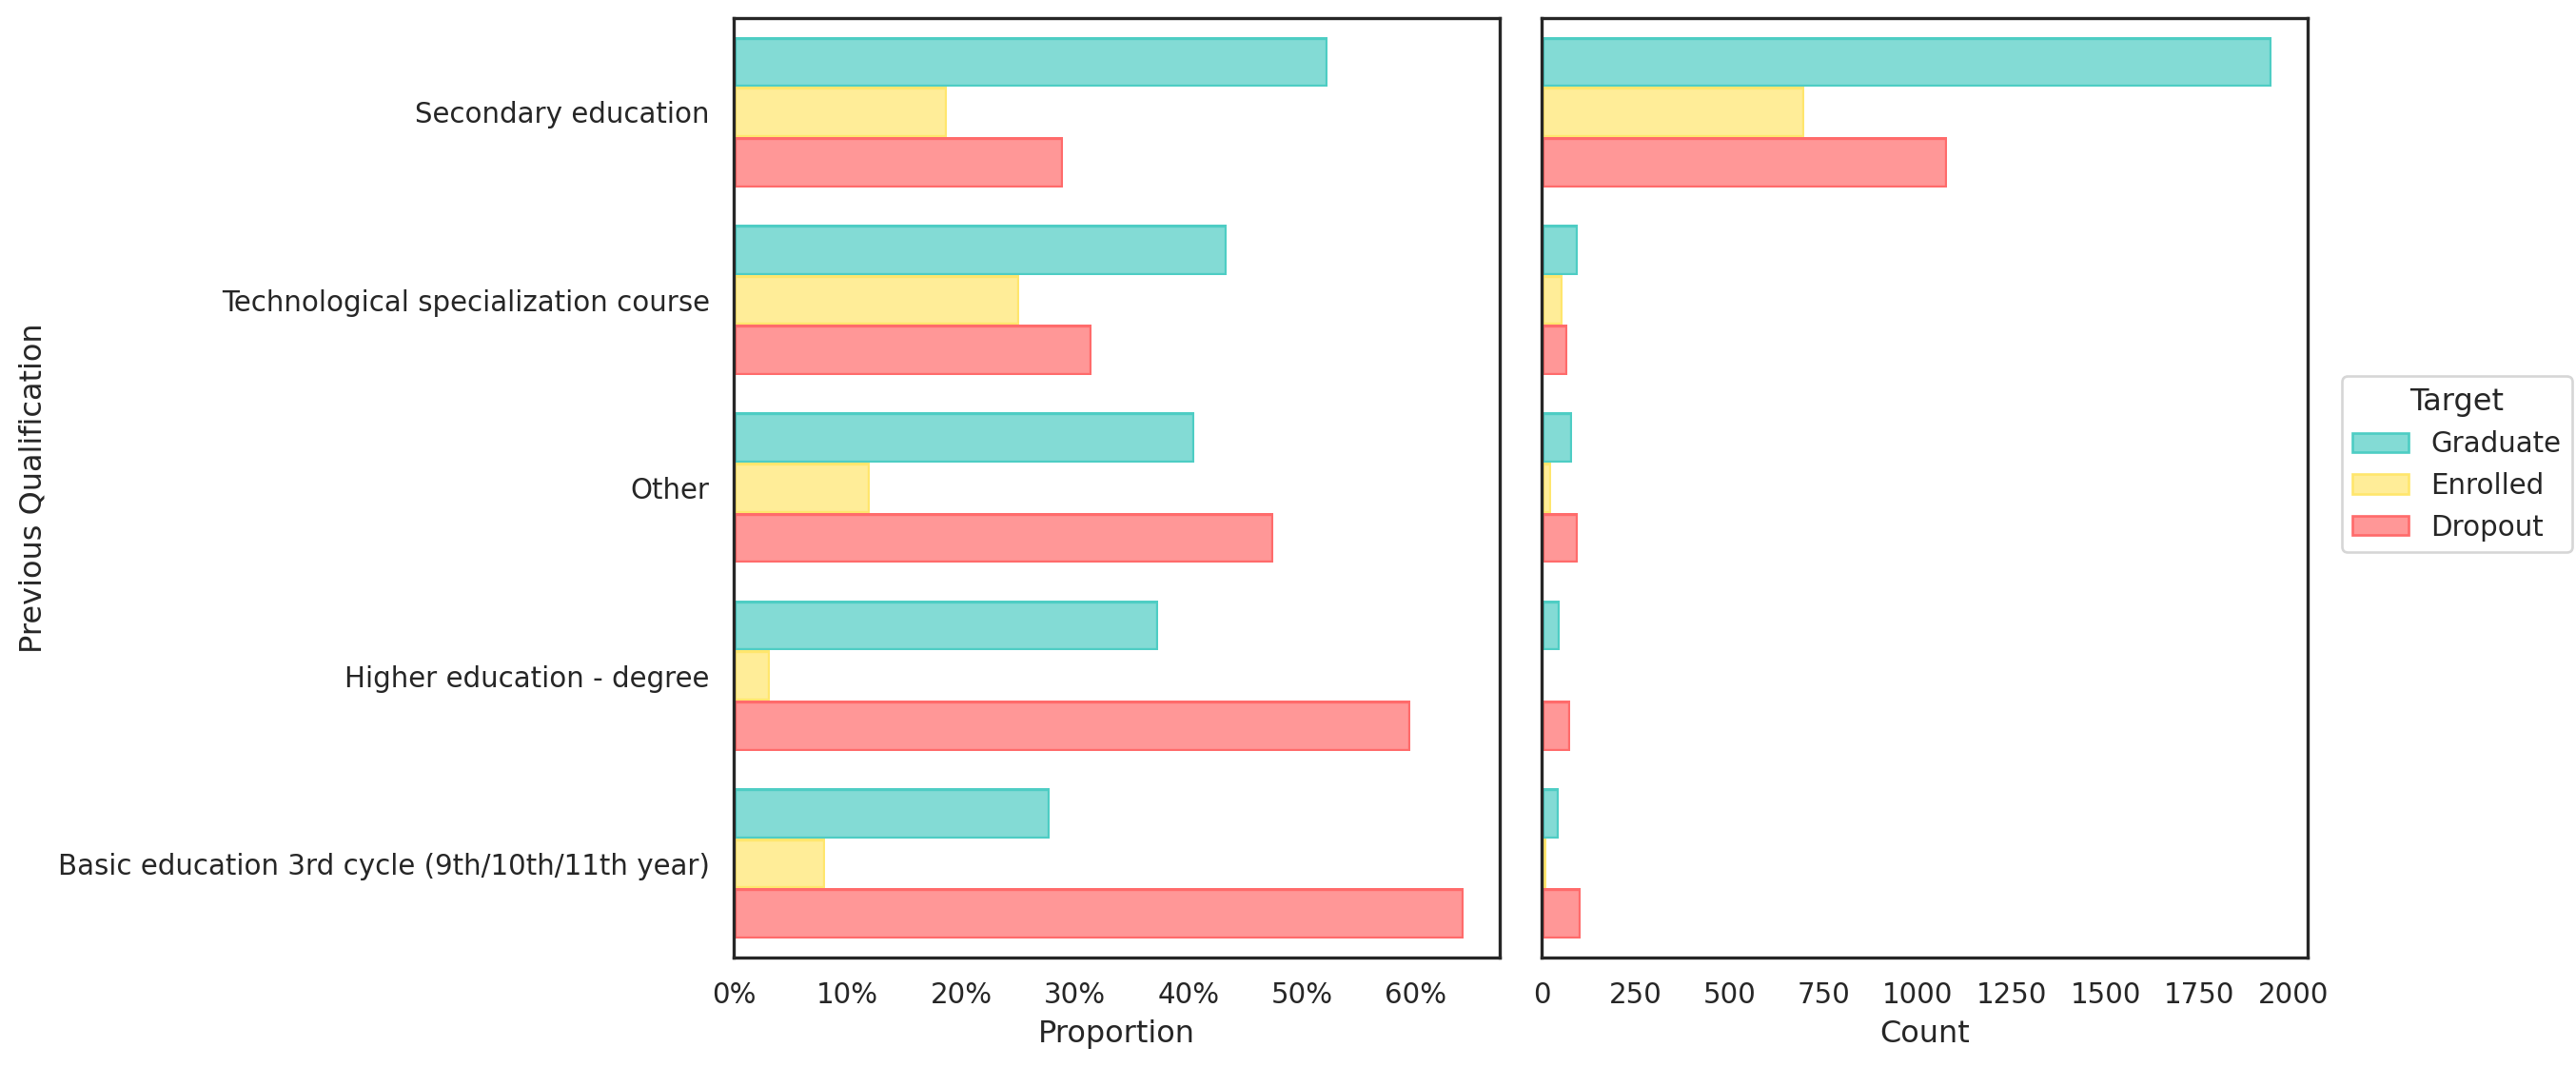

In [14]:
(students
 .assign(previous_qualification = lambda x: fct_lump(x.previous_qualification, 4))
 .pipe(plot_proportions, "previous_qualification")
)

Most of the students have a secondary education degree, so there is not a lot of data in the other categories, but the dropout rates in this rare categories is really high (~ 60%). Is it by chance or this could be a good predictor?

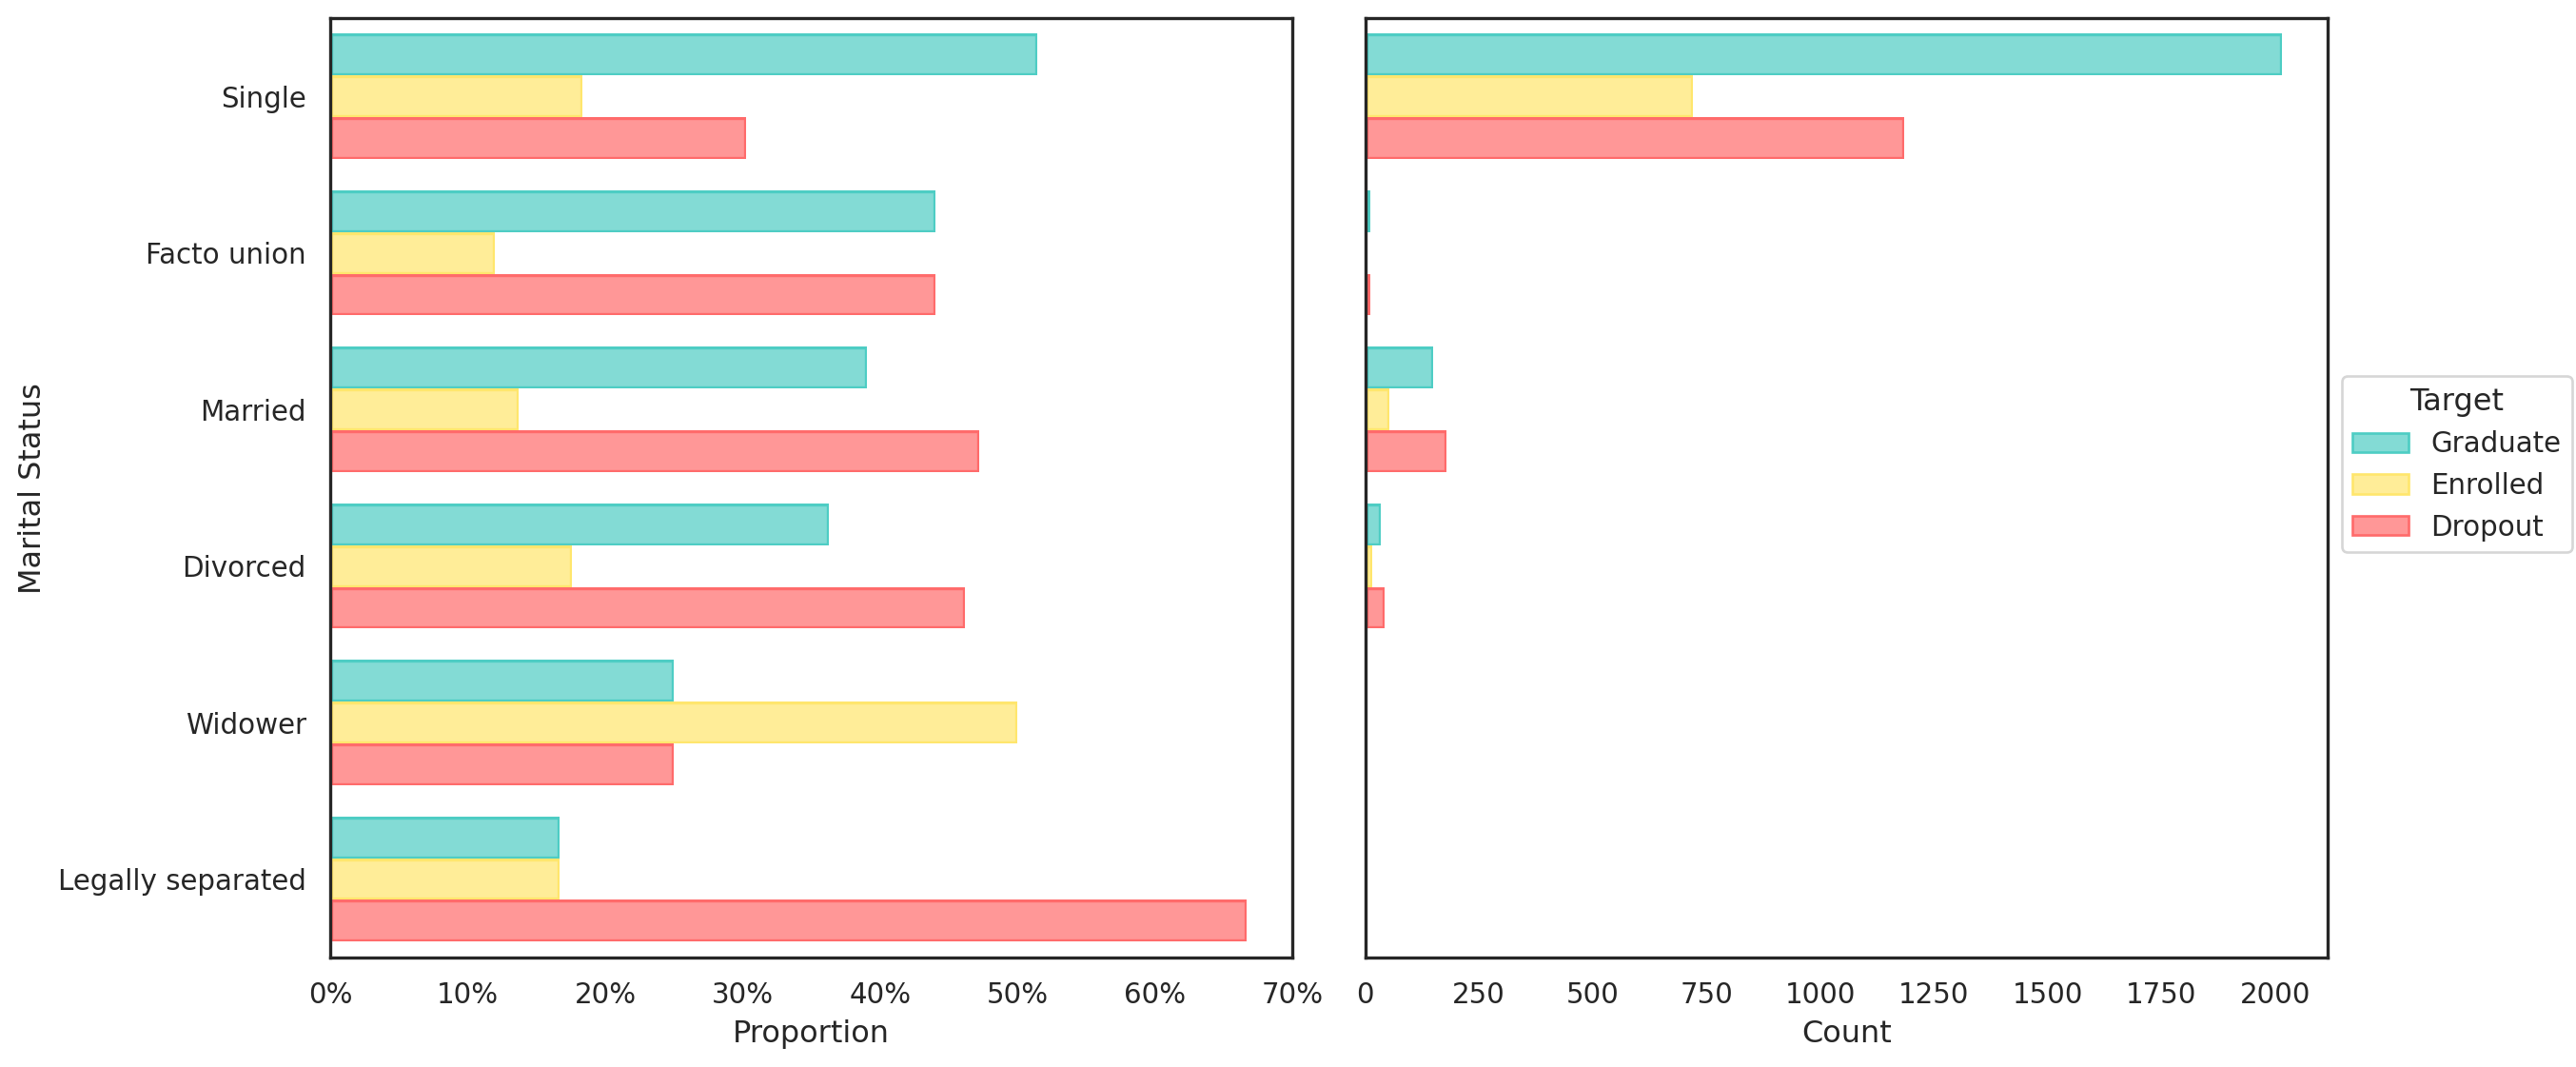

In [15]:
students.pipe(plot_proportions, "marital_status")

The big majority of the students are single (more than 80% of the total)

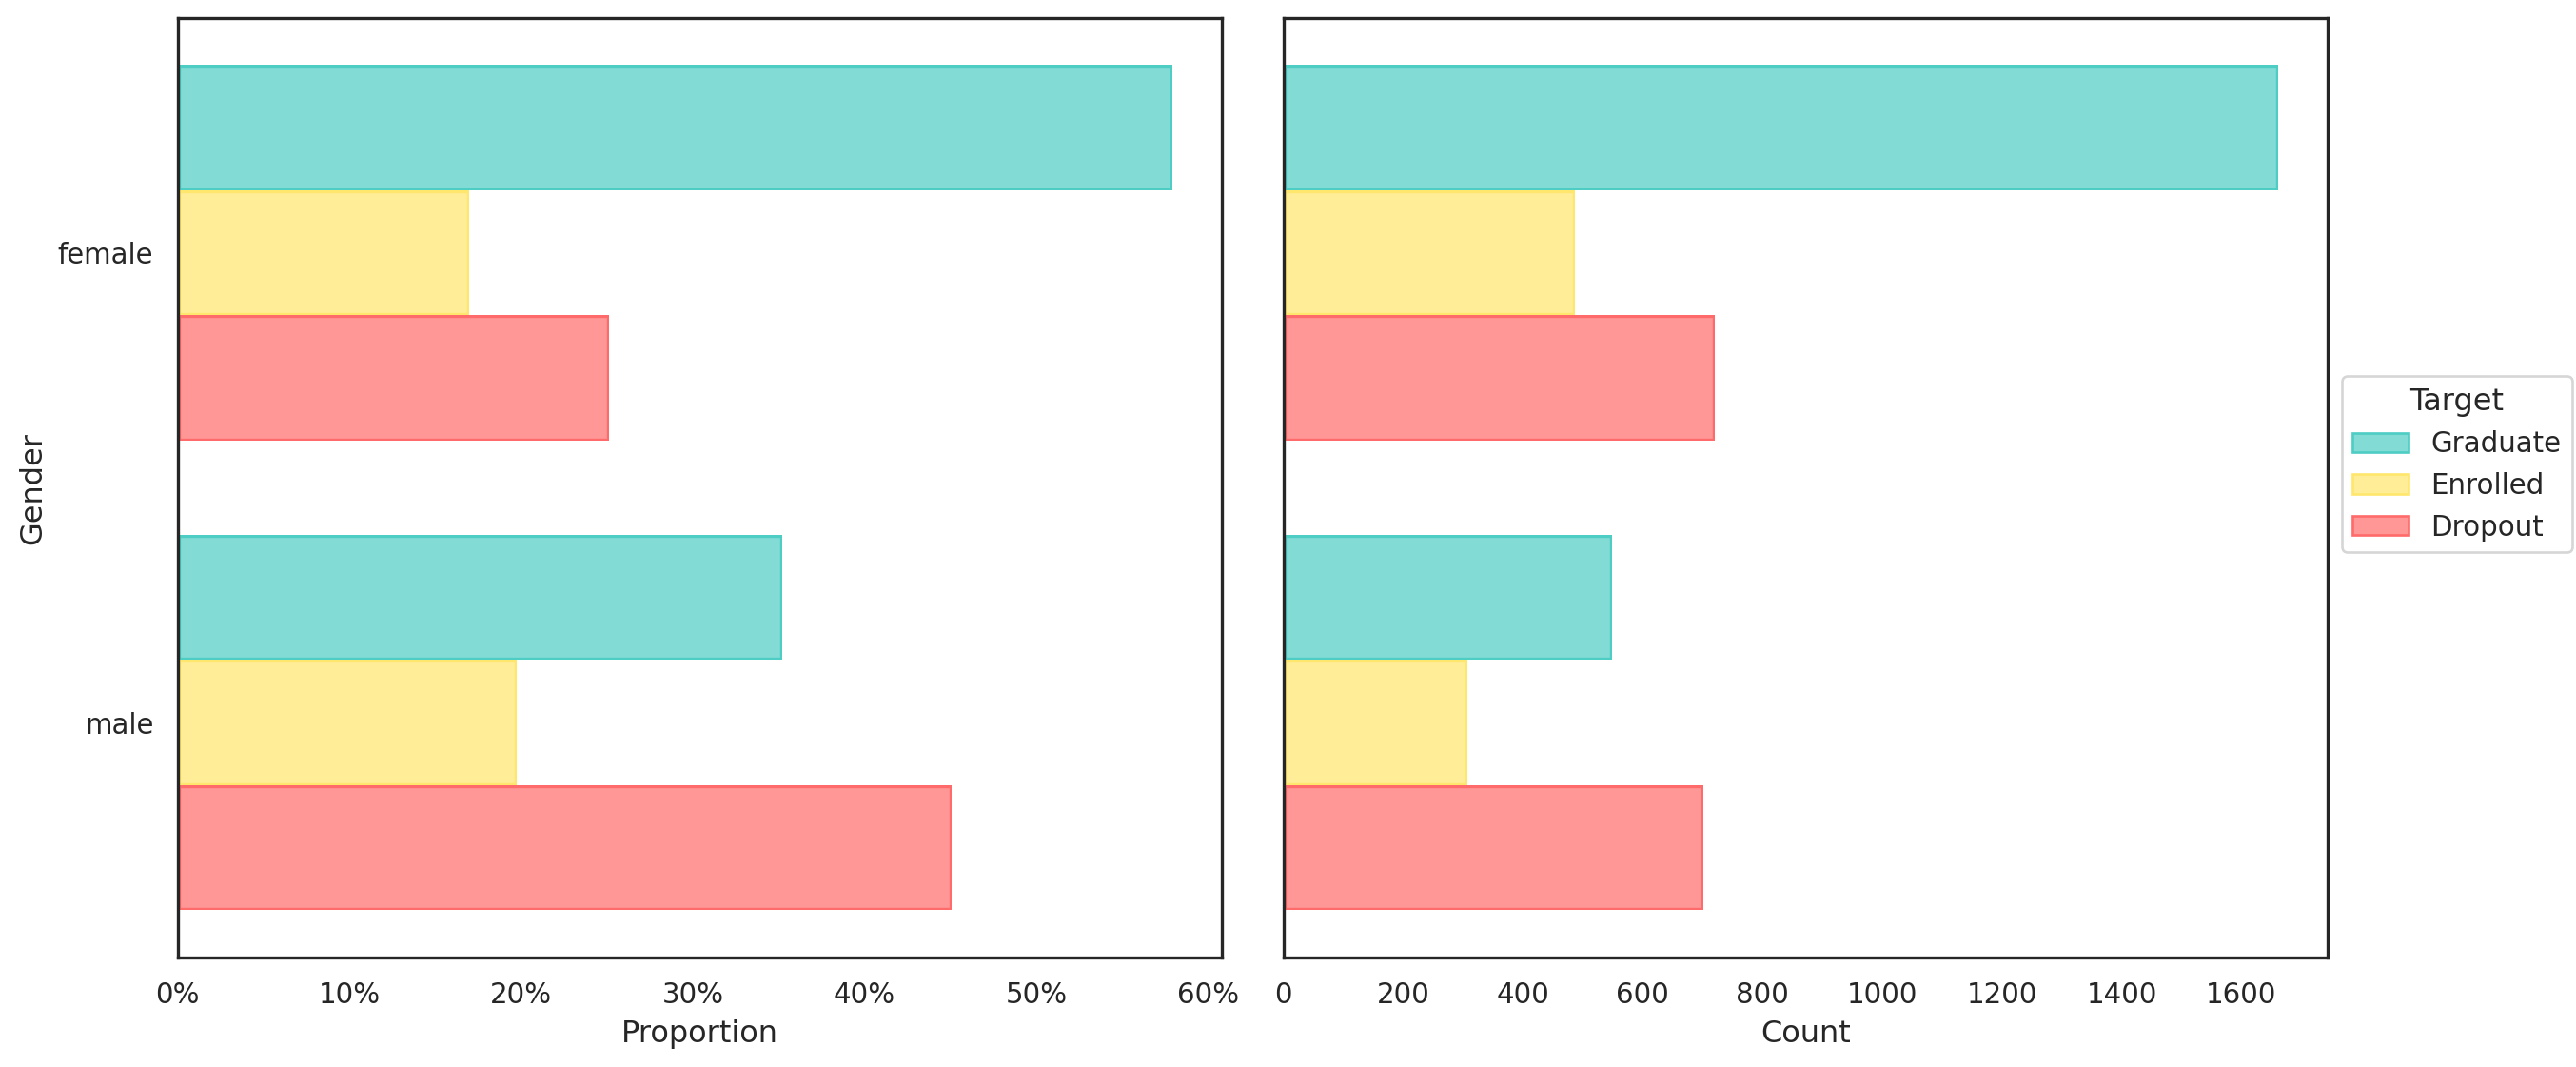

In [16]:
students.pipe(plot_proportions, "gender")

Big difference between men and women in graduations rate. Most of the men dropout whilst most of the women graduate. Is this a gender capacity difference? Are women more studious than men? or is there another [confounding variable](https://en.wikipedia.org/wiki/Confounding) affecting the outcome? For instance, in STEM (Science, technology, engineering, and mathematics) courses the majority of the students are men, and we saw before that these courses have the major dropout rates in contrast to social disciplines. I will analyze this deeper later.

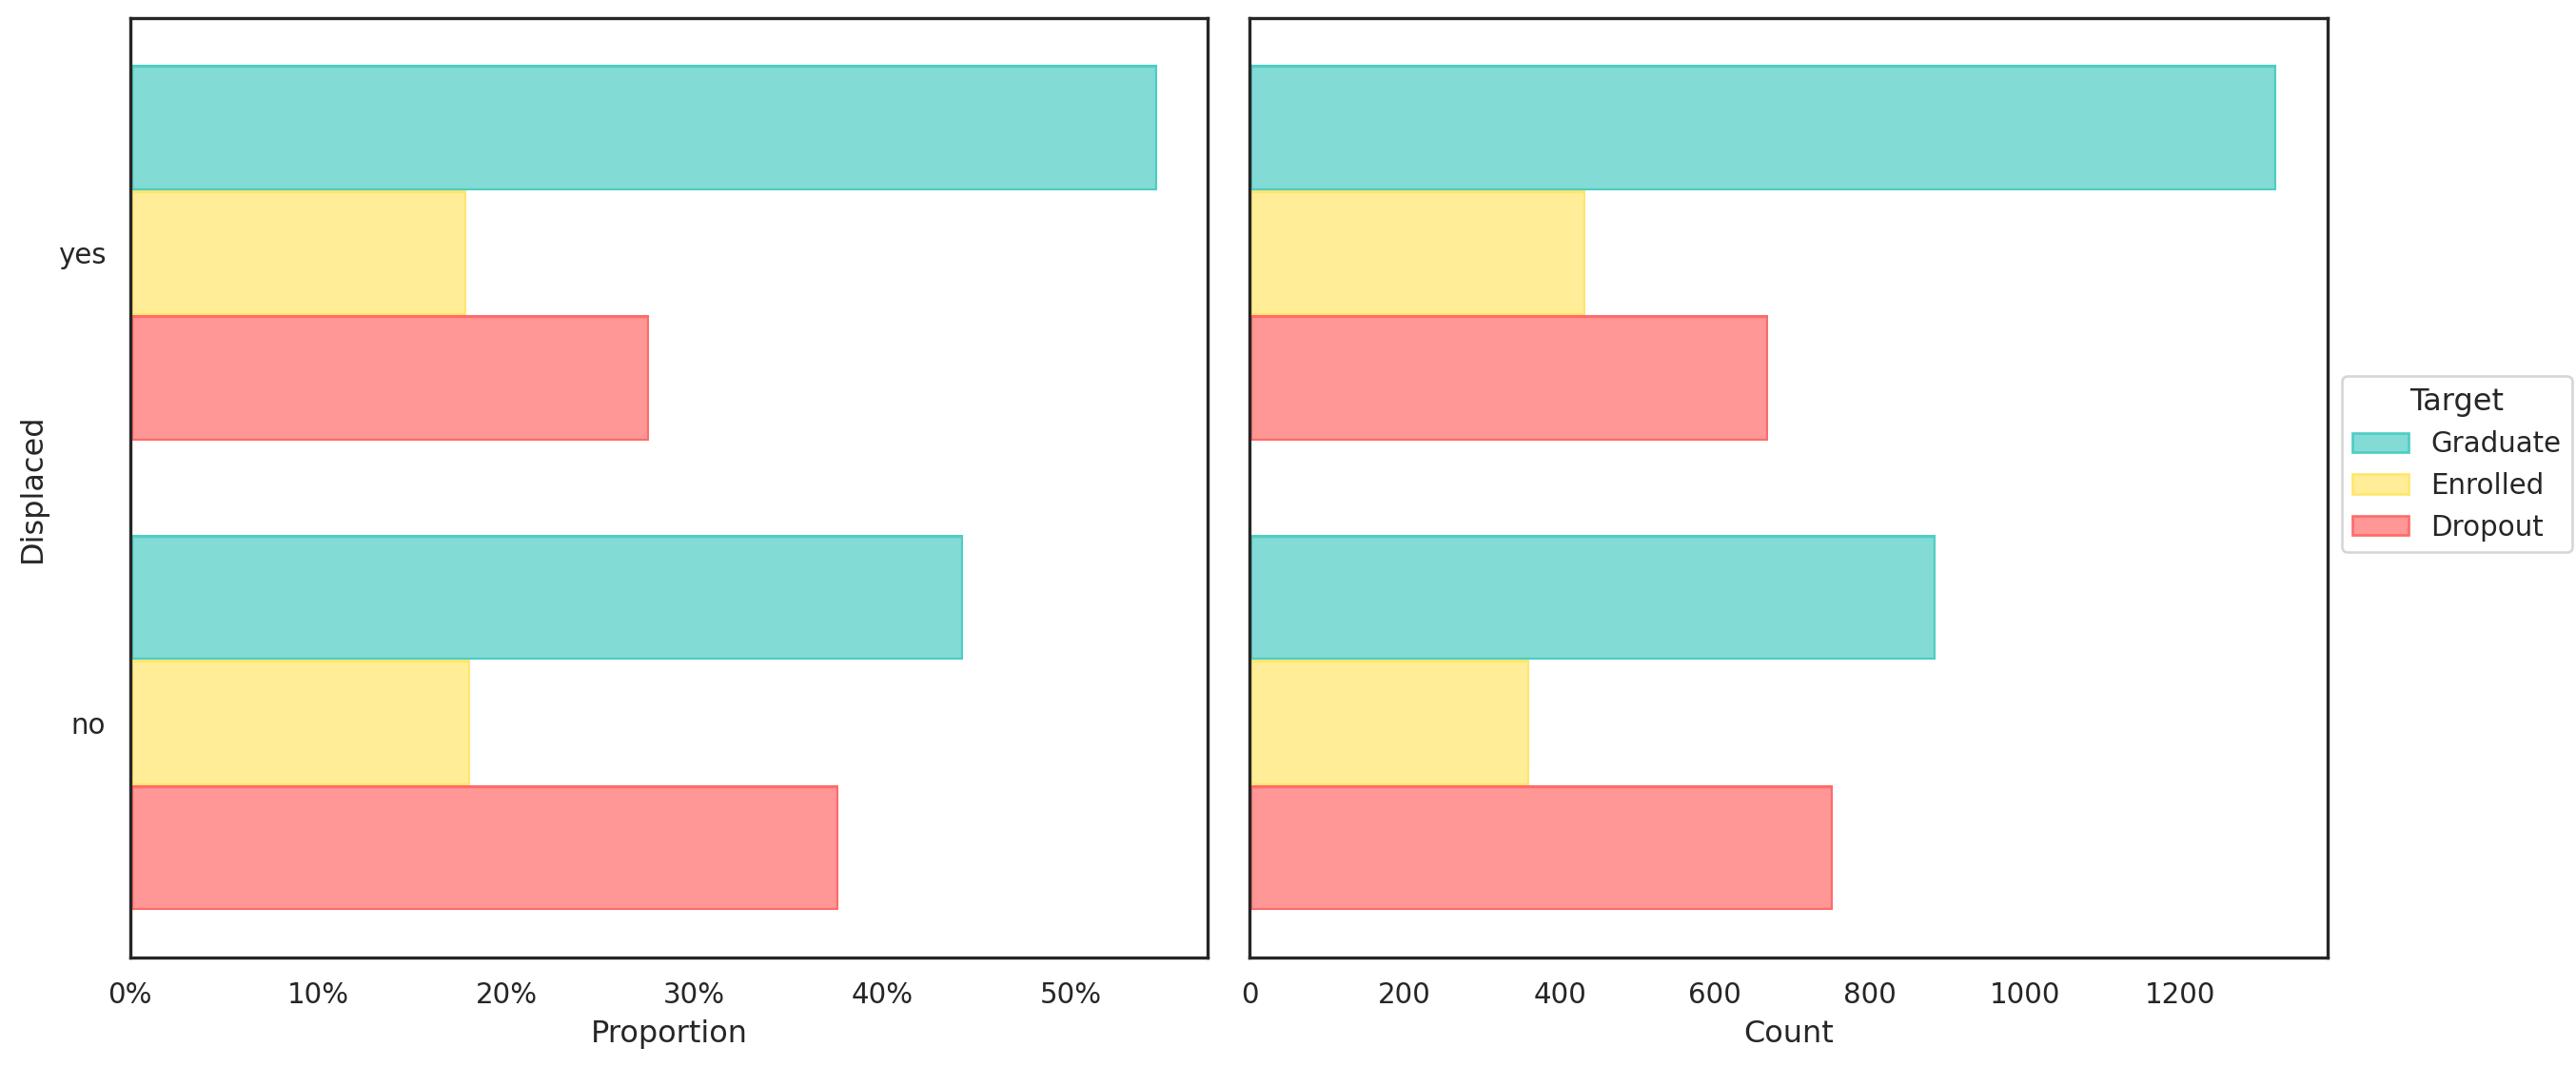

In [17]:
students.pipe(plot_proportions, "displaced")

Those who displaced are more likely to graduate and less likely to dropout

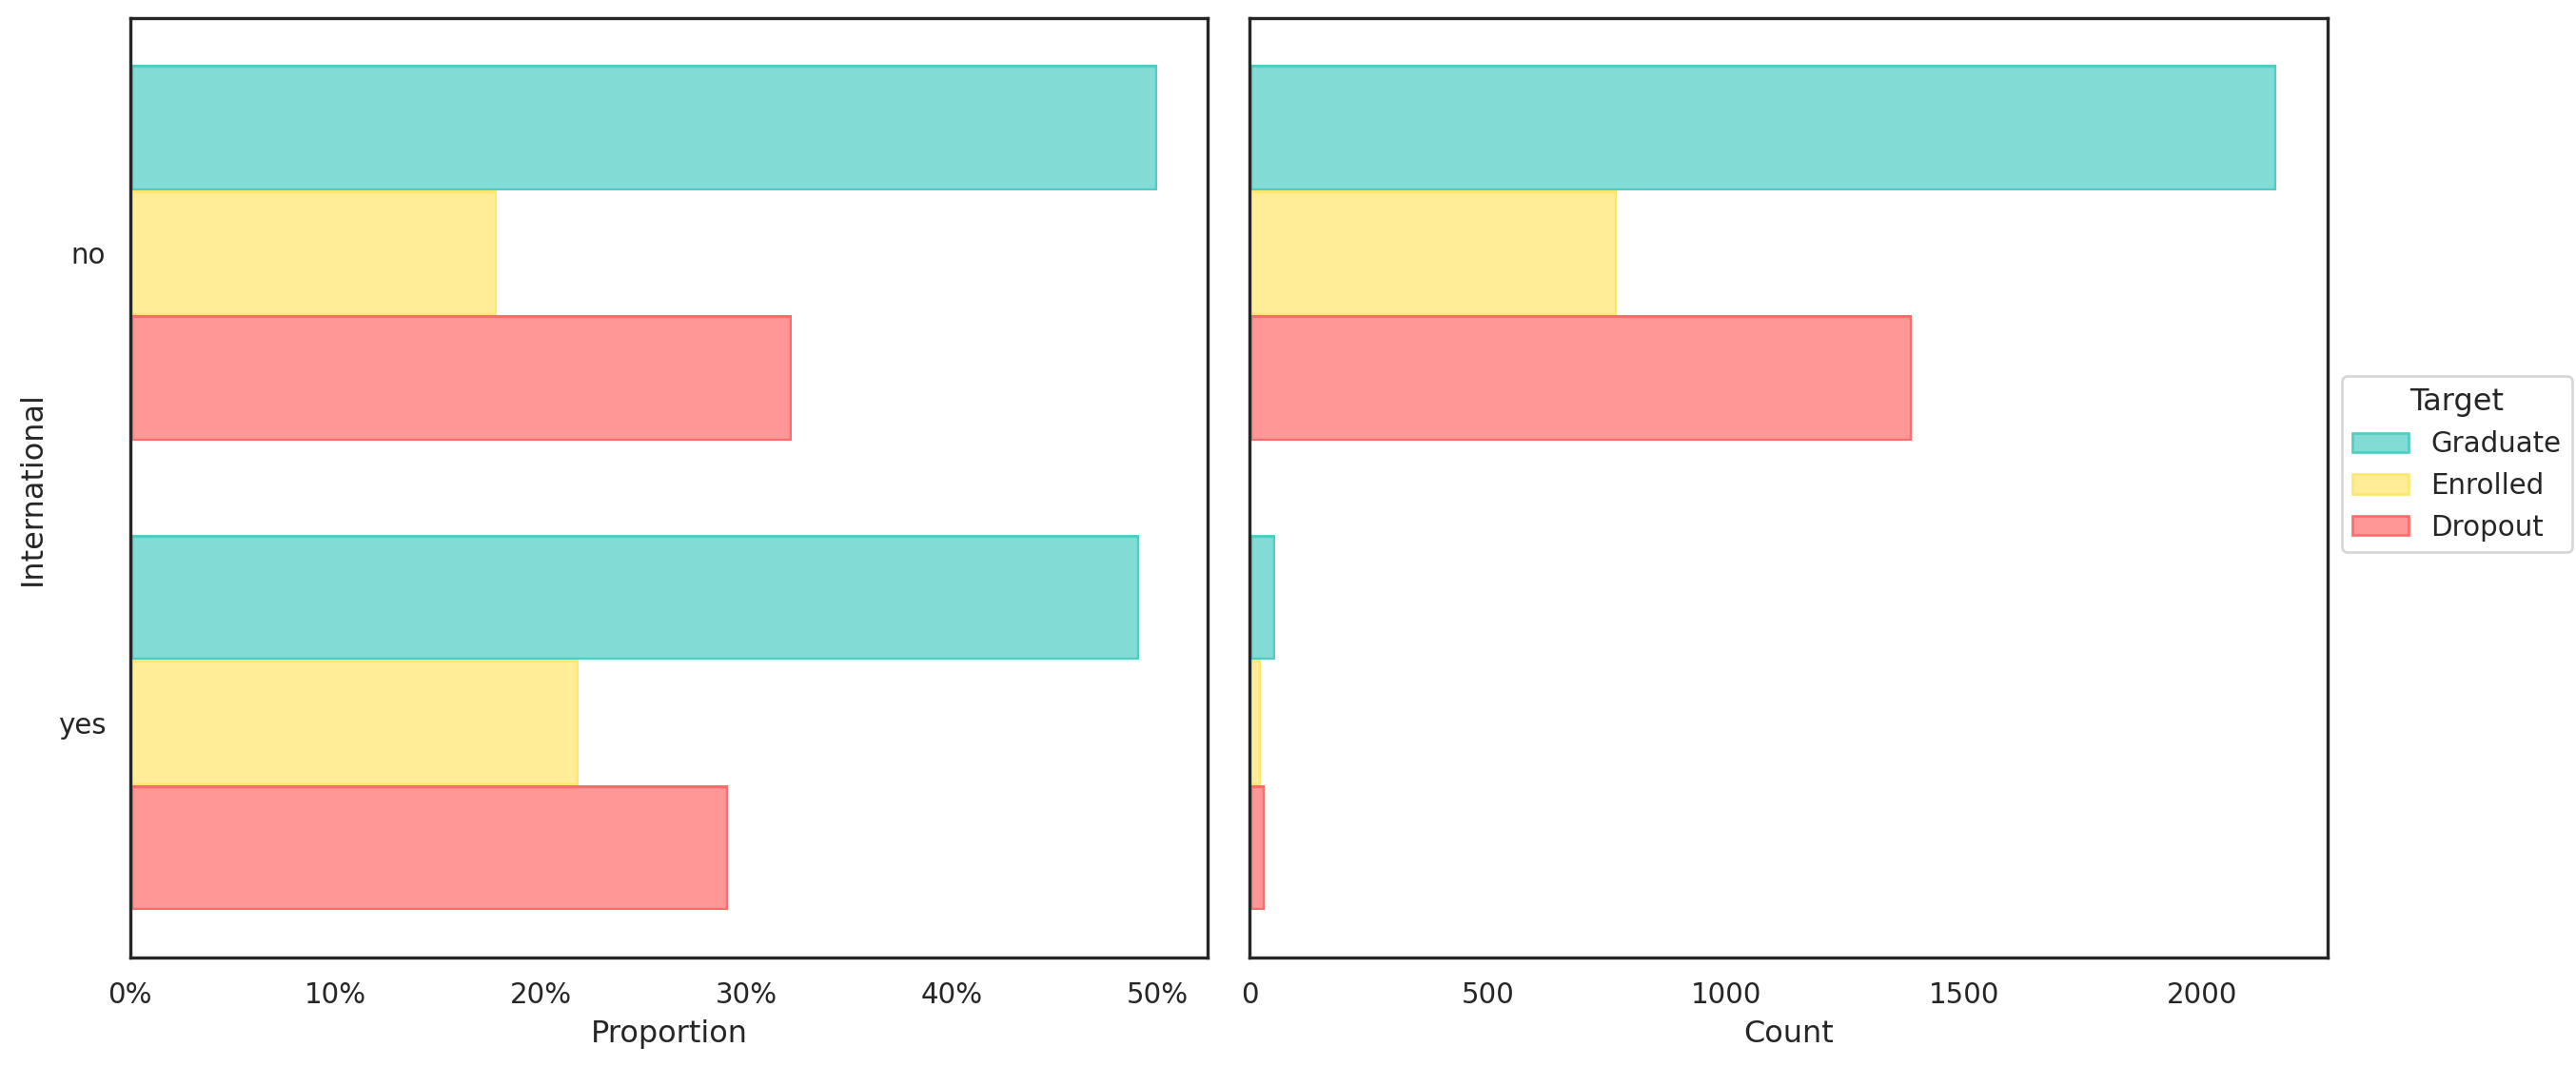

In [18]:
students.pipe(plot_proportions, "international")

In [52]:
students.value_counts("international", normalize=True)

international
no     0.975136
yes    0.024864
dtype: float64

International students only account for 2.5% of the total data, the proportion within each group seems to be the same, that's why this one is probably not a good predictor.

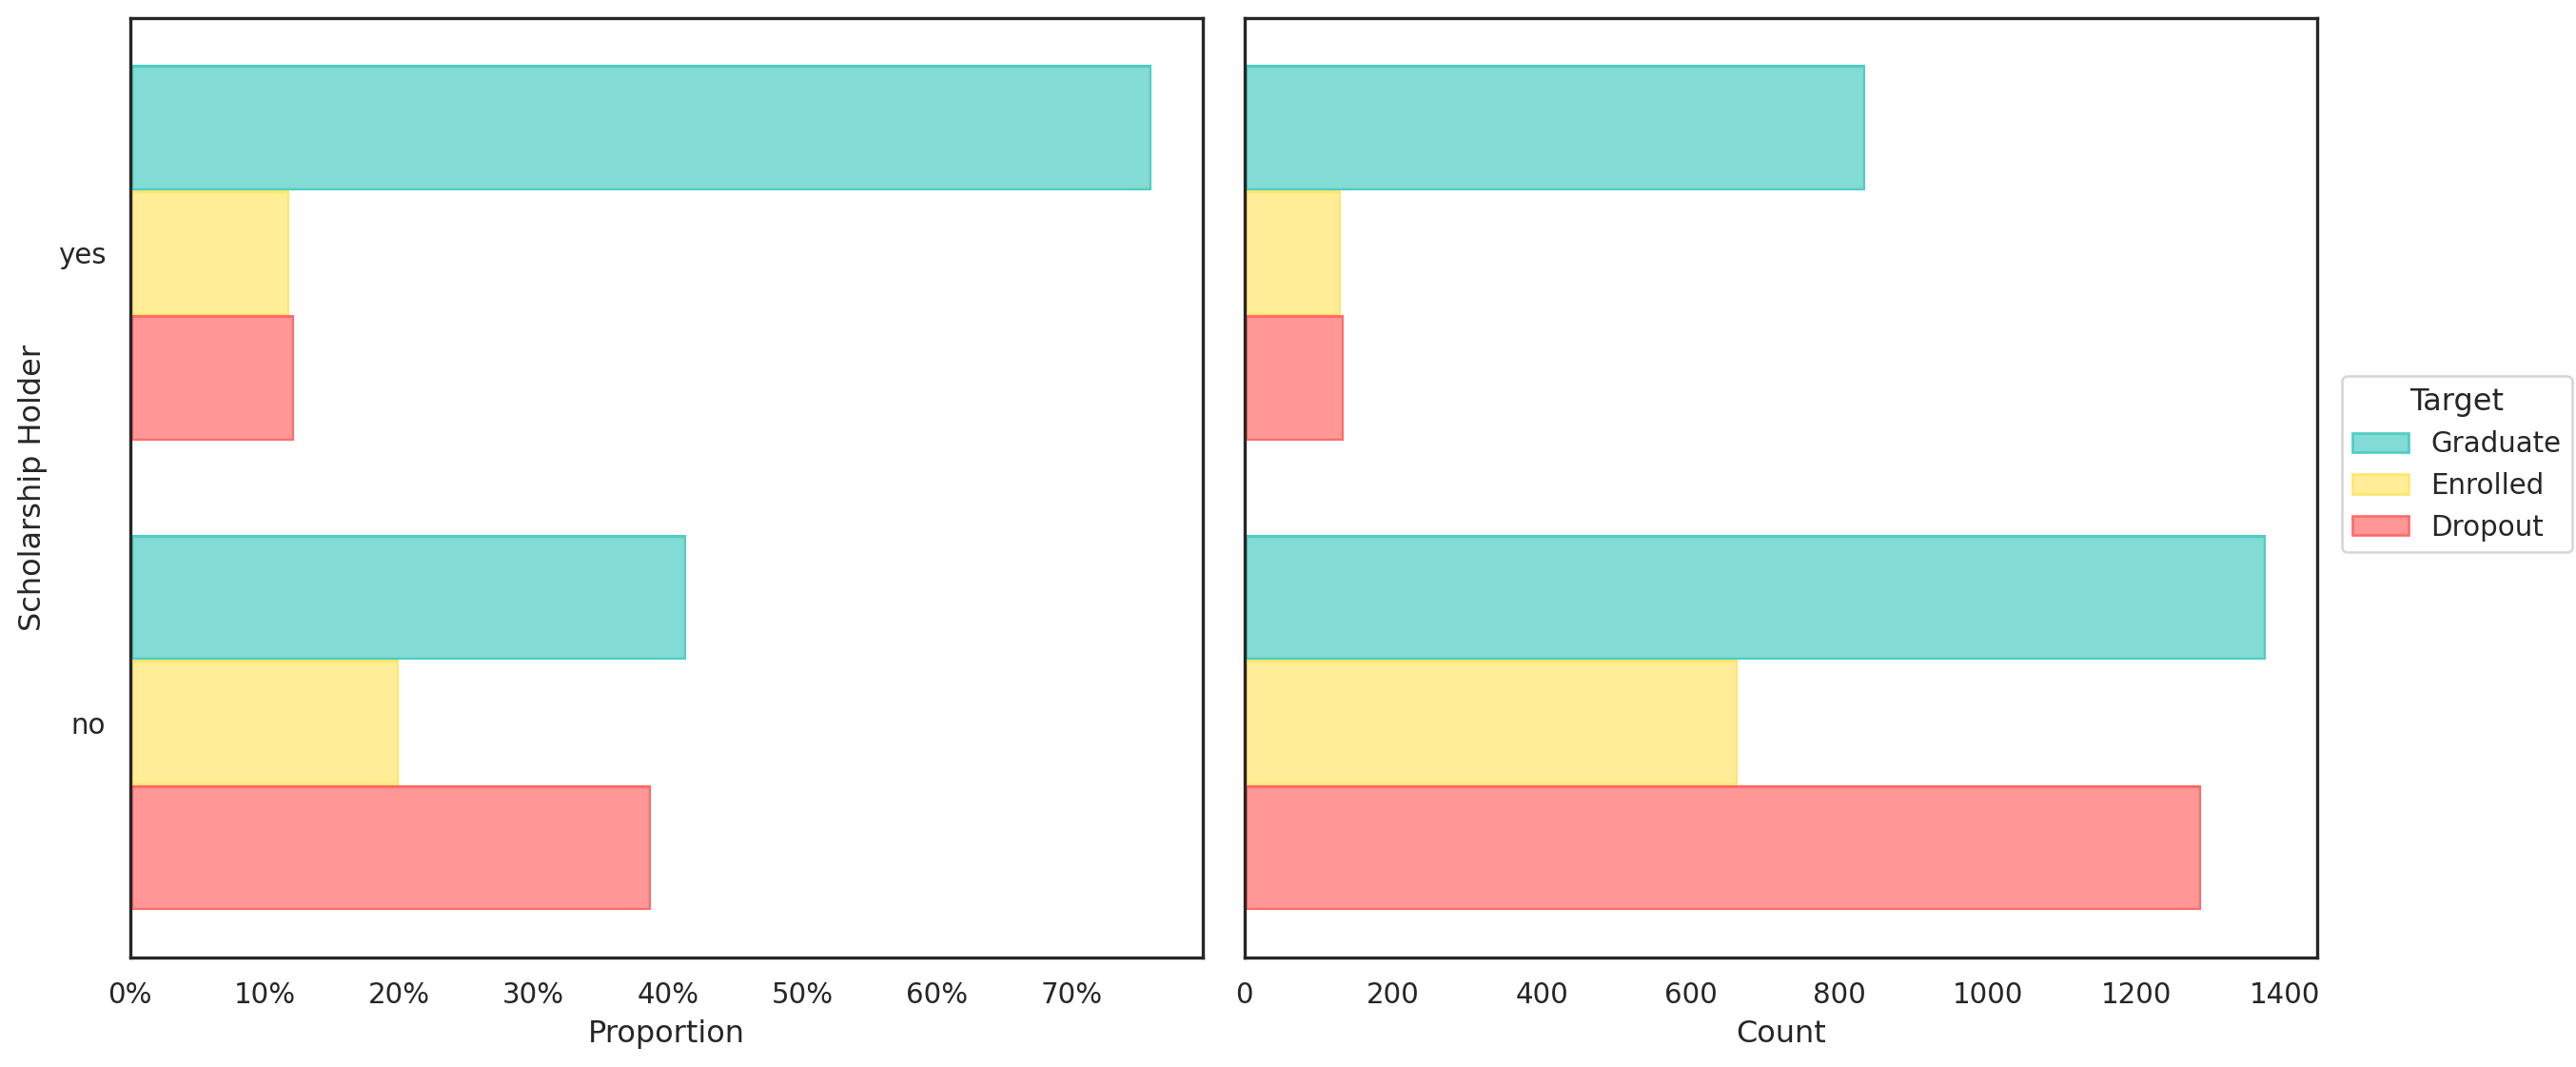

In [19]:
students.pipe(plot_proportions, "scholarship_holder")

Wow, looks like scholarships are a great predictor of graduation, but correlation is not causation. Are scholarships making students more likely to graduate or is it that students that get scholarships are those with better grades and that is causing the higher graduation rate? I will dig up into this subject later

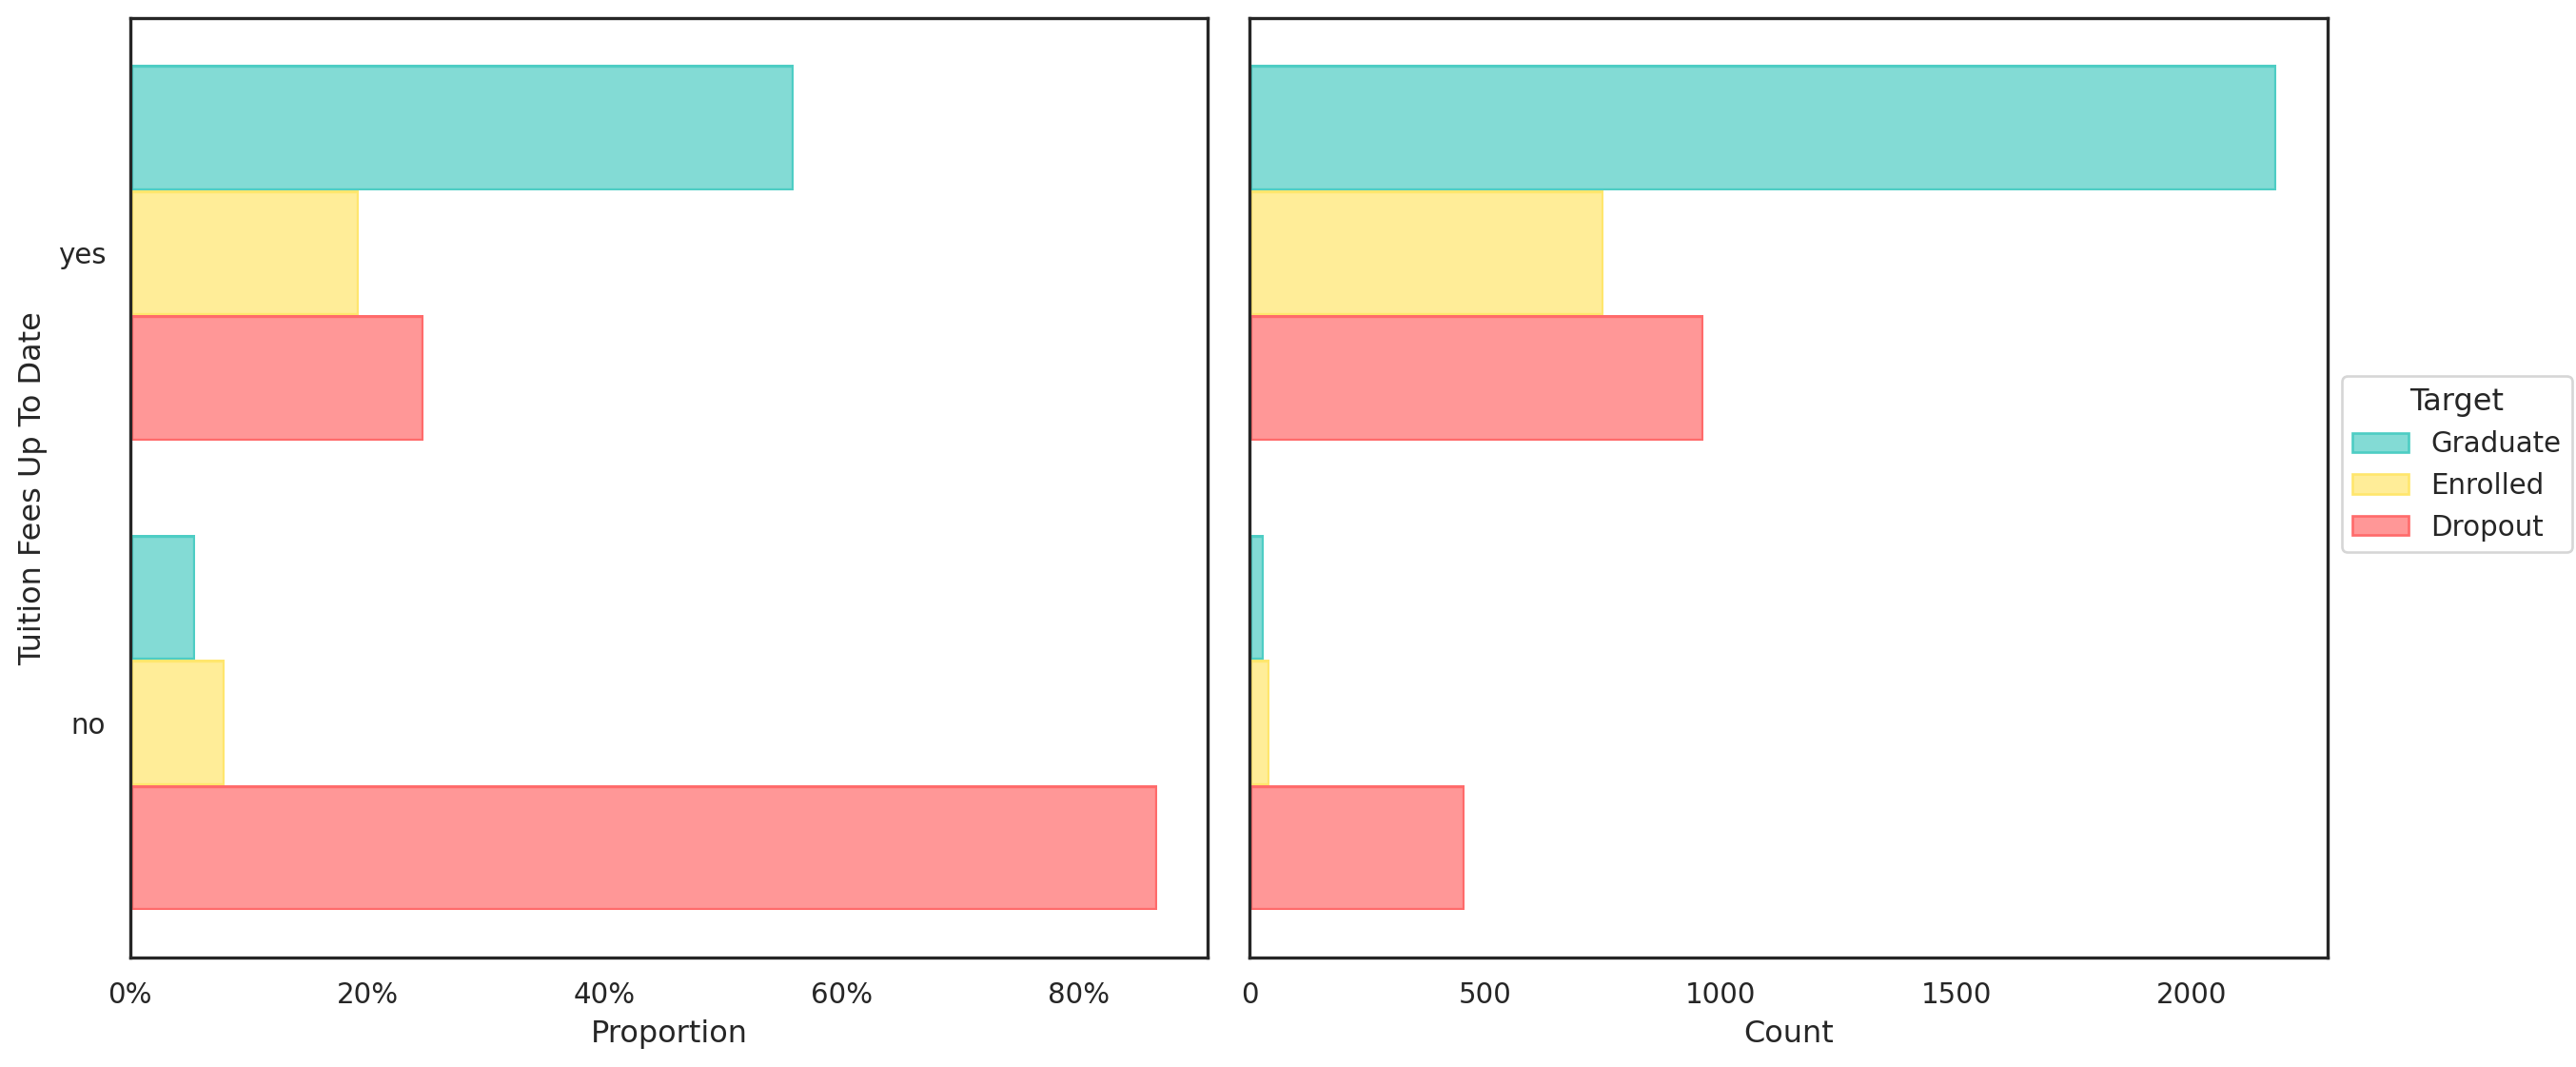

In [20]:
students.pipe(plot_proportions, "tuition_fees_up_to_date")

Those who don't have their tuition fee up to date are really likely (85%) of dropout. This makes sense, once you know you will leave, you stop paying. Probably this is a great indicator for the university, those who stop paying their tuition are really likely to dropout, follow up those cases and check what is happening.

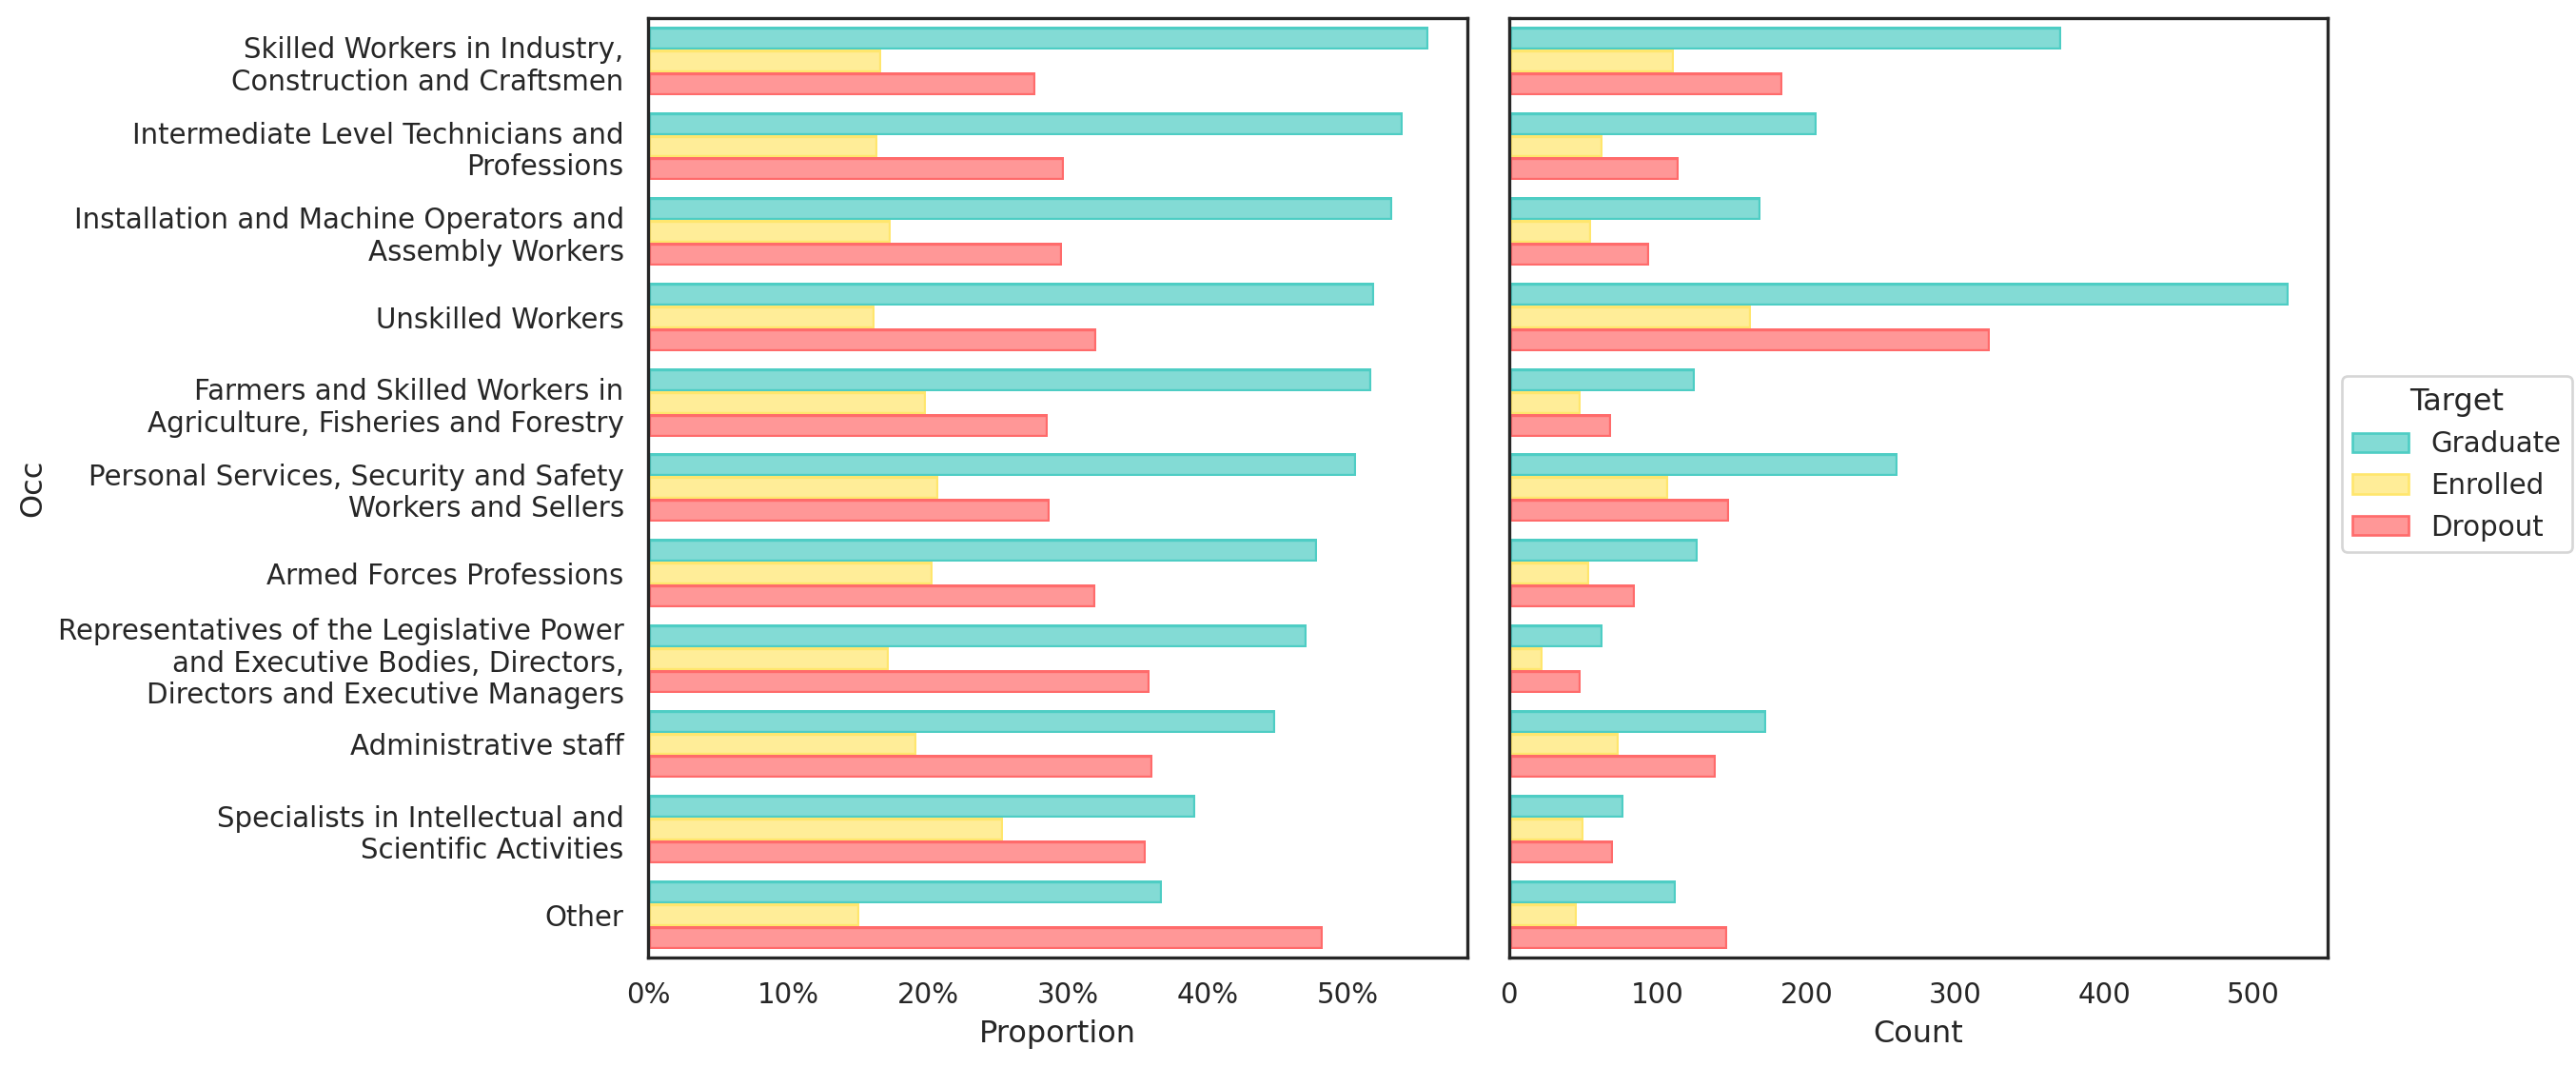

In [21]:
from textwrap import wrap
(students
 .assign(occ = lambda x: fct_lump(x["father's_occupation"], 10))
 .assign(occ = lambda x: x.occ.apply(lambda y: "\n".join(wrap(y, width=40, expand_tabs=False))))
 .pipe(plot_proportions, "occ")
)

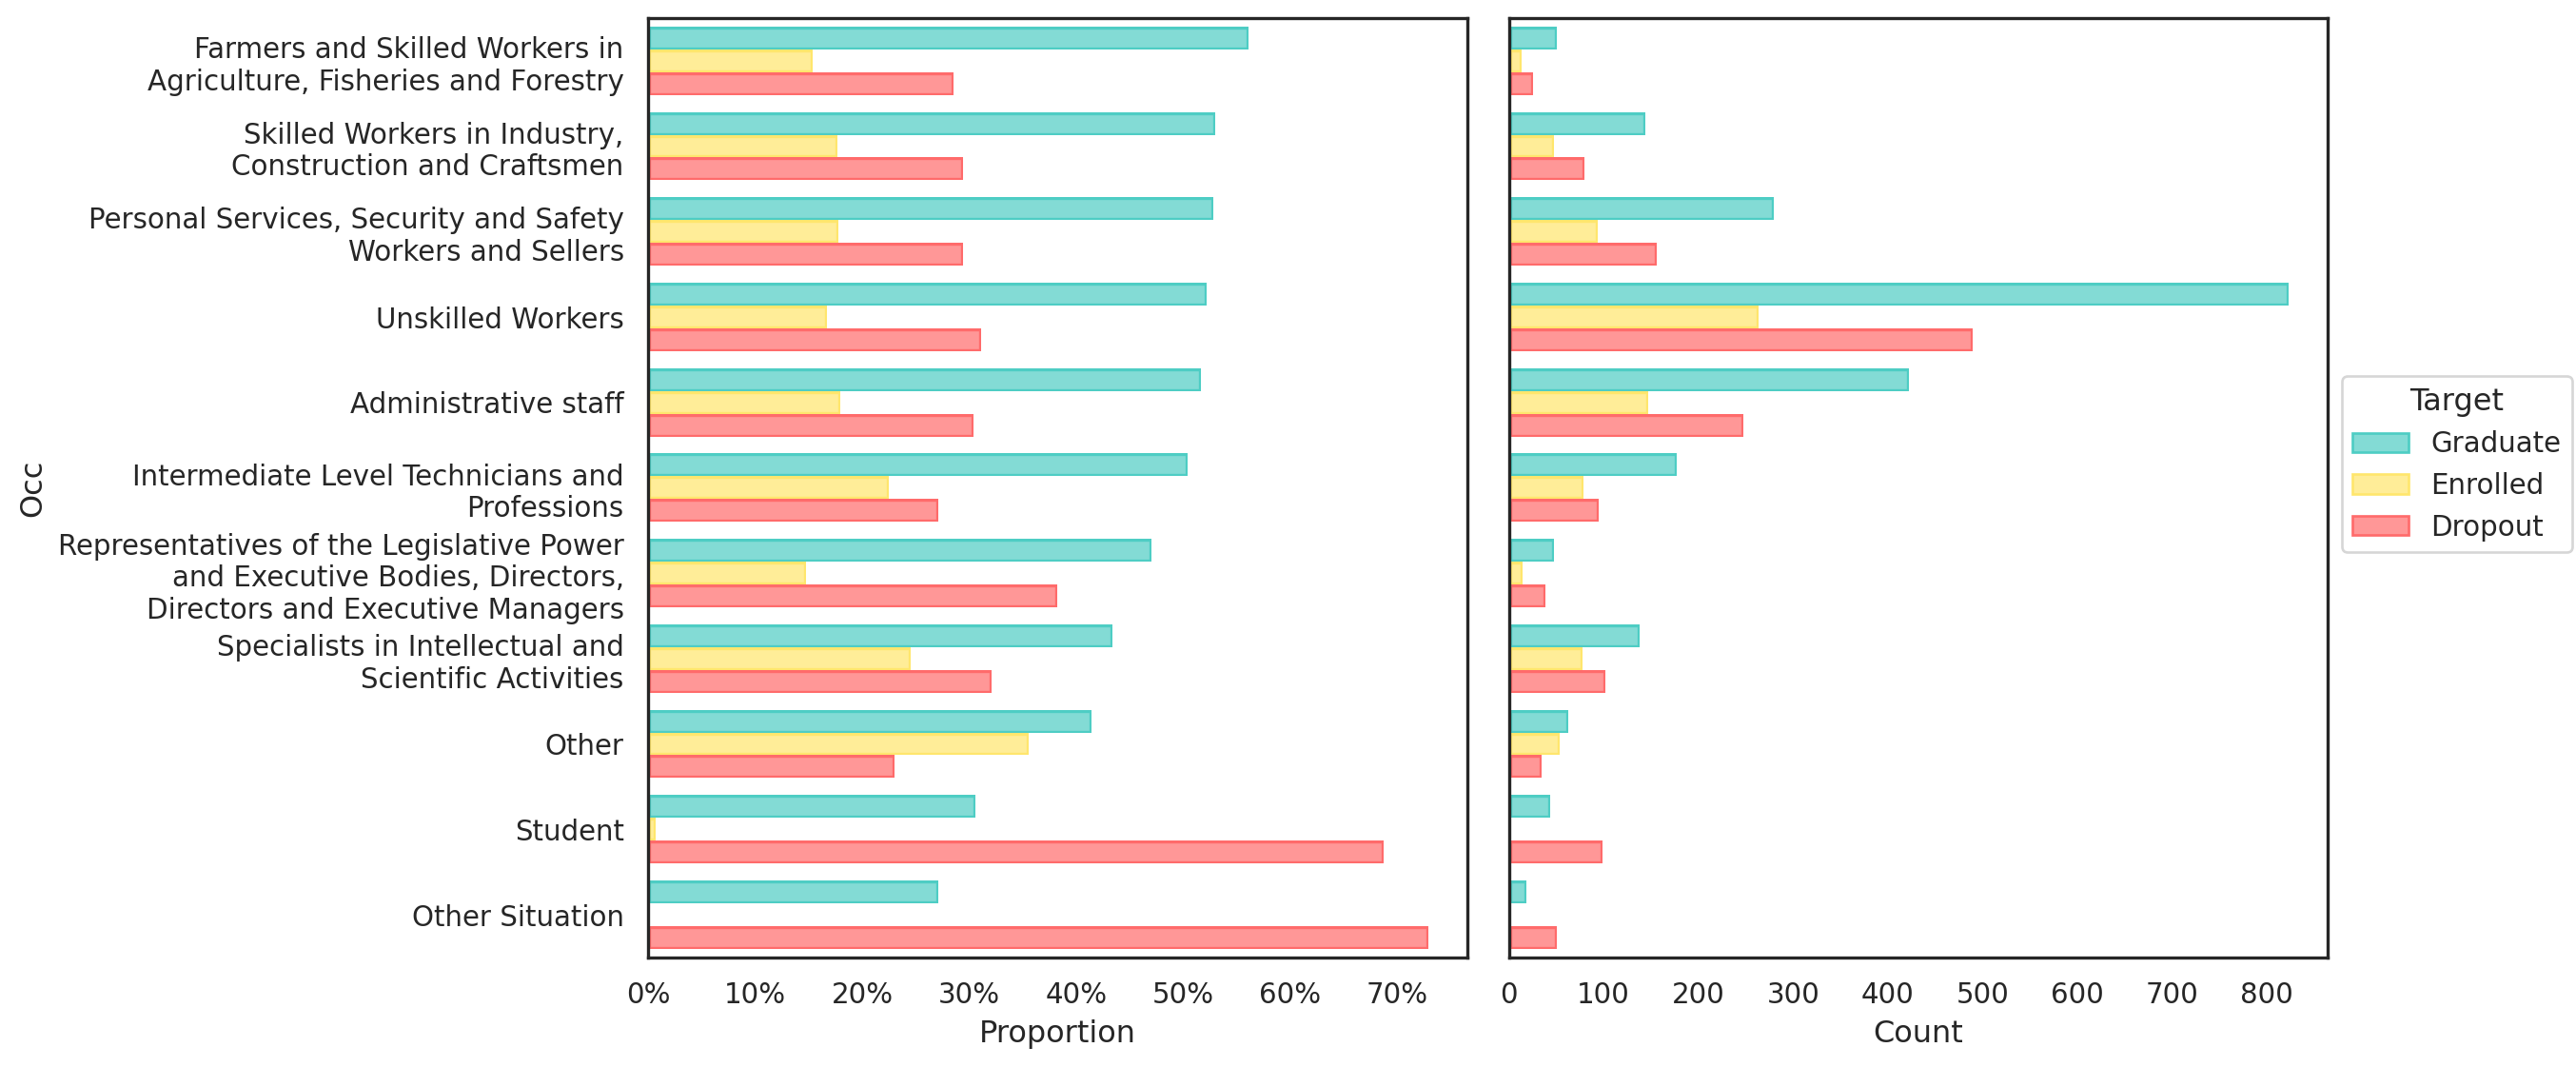

In [22]:
from textwrap import wrap
(students
 .assign(occ = lambda x: fct_lump(x["mother's_occupation"], 10))
 .assign(occ = lambda x: x.occ.apply(lambda y: "\n".join(wrap(y, width=40, expand_tabs=False))))
 .pipe(plot_proportions, "occ")
)

In [23]:
parents_occupation = pd.concat([students["mother's_occupation"], students["father\'s_occupation"]])
parents_occupation.value_counts().head(15)

Unskilled Workers                                                                                             2587
Administrative staff                                                                                          1203
Personal Services, Security and Safety Workers and Sellers                                                    1046
Skilled Workers in Industry, Construction and Craftsmen                                                        938
Intermediate Level Technicians and Professions                                                                 735
Specialists in Intellectual and Scientific Activities                                                          515
Installation and Machine Operators and Assembly Workers                                                        354
Farmers and Skilled Workers in Agriculture, Fisheries and Forestry                                             333
Student                                                                         

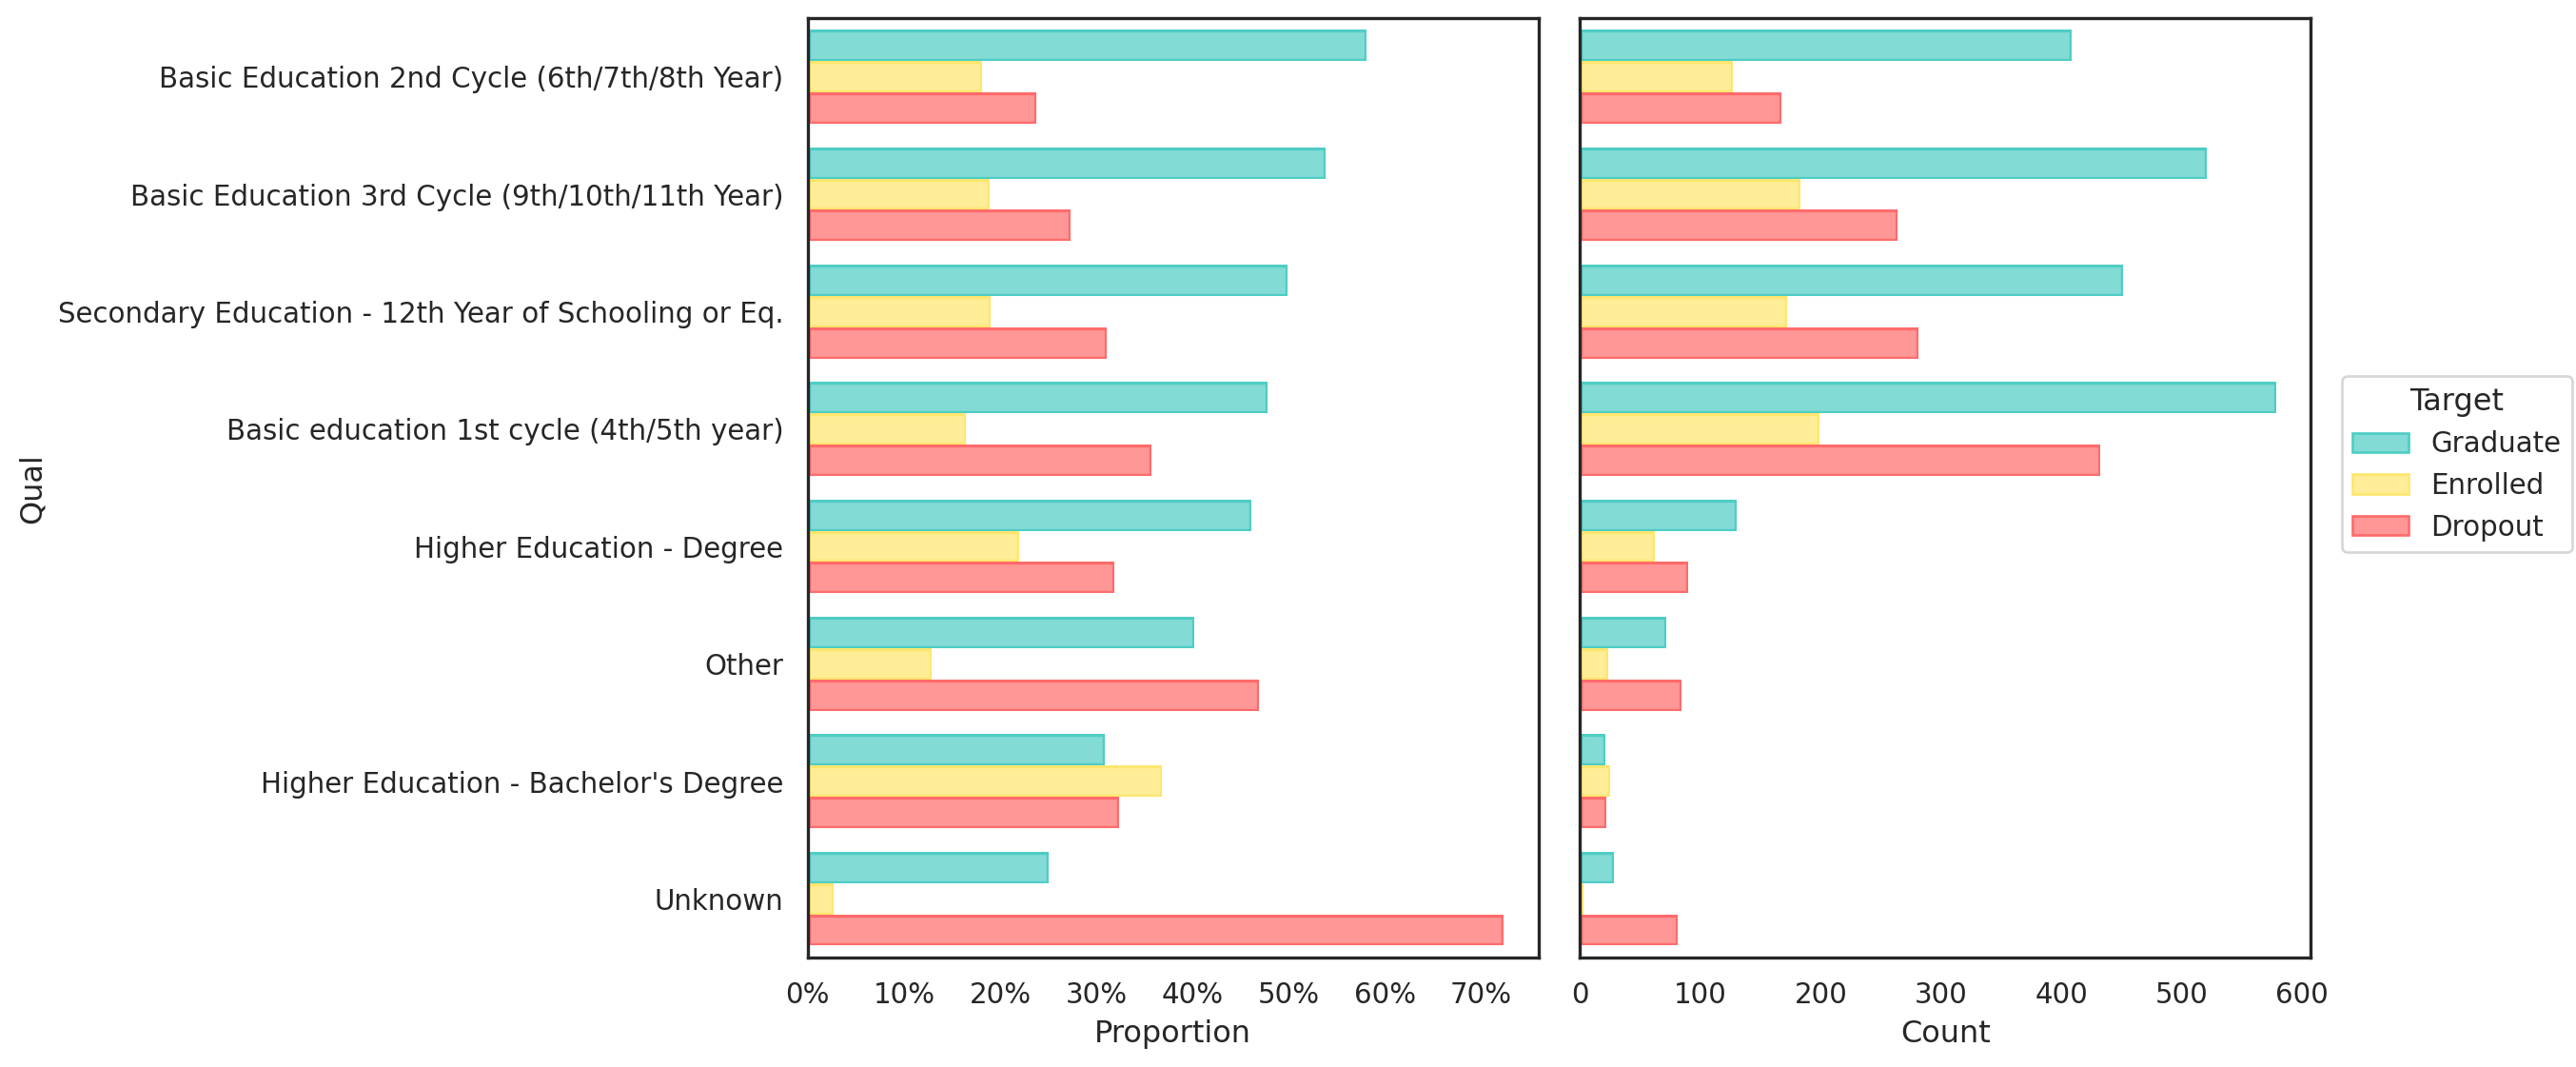

In [24]:
students.assign(qual = lambda x:fct_lump(x["father's_qualification"],7)).pipe(plot_proportions, "qual")

In [25]:
parents_qualification = pd.concat([students["mother\'s_qualification"], students["father\'s_qualification"]])
parents_qualification.value_counts().head(15)

Secondary Education - 12th Year of Schooling or Eq.    1973
Basic education 1st cycle (4th/5th year)               1213
General Course of Administration and Commerce          1010
Basic Education 3rd Cycle (9th/10th/11th Year)          969
General commerce course                                 954
Higher Education - Degree                               720
Basic Education 2nd Cycle (6th/7th/8th Year)            706
Supplementary Accounting and Administration             563
Higher Education - Bachelor's Degree                    151
2nd cycle of the general high school course             131
Unknown                                                 120
Higher Education - Master's                              88
Other - 11th Year of Schooling                           80
Higher Education - Doctorate                             39
Technological specialization course                      21
dtype: int64

It doesn't seems like the level of education of the parents or their job makes great difference in their children studies success. There seems to be a little negative correlation between success in studies and parents salaries and qualifications. Maybe this occurs because students with higher income parents are more likely to go to high level universities, and these are harder to approve? I 

<AxesSubplot: xlabel='age_at_enrollment', ylabel='Density'>

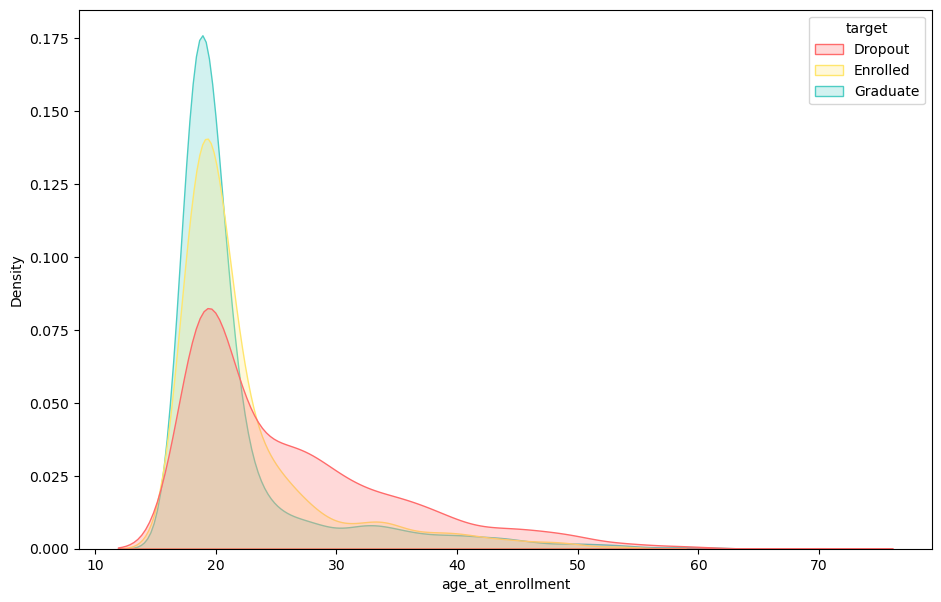

In [26]:
sns.kdeplot(students, x = "age_at_enrollment", hue = "target", fill = True, common_norm=False, palette=target_palette)

<AxesSubplot: xlabel='unemployment_rate', ylabel='Count'>

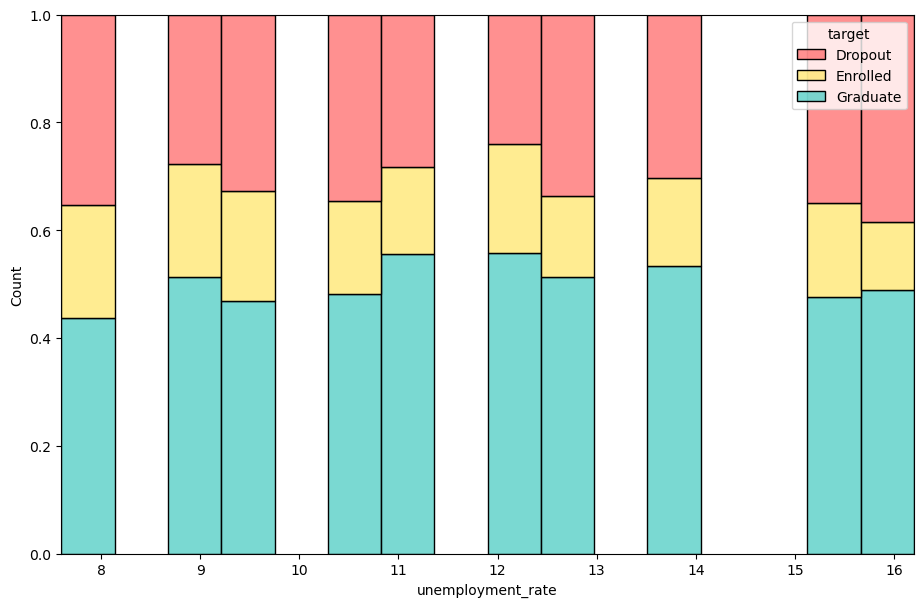

In [27]:
sns.histplot(students, x = "unemployment_rate", hue = "target", stat= "count", multiple="fill", palette=target_palette)

<AxesSubplot: xlabel='gdp', ylabel='Count'>

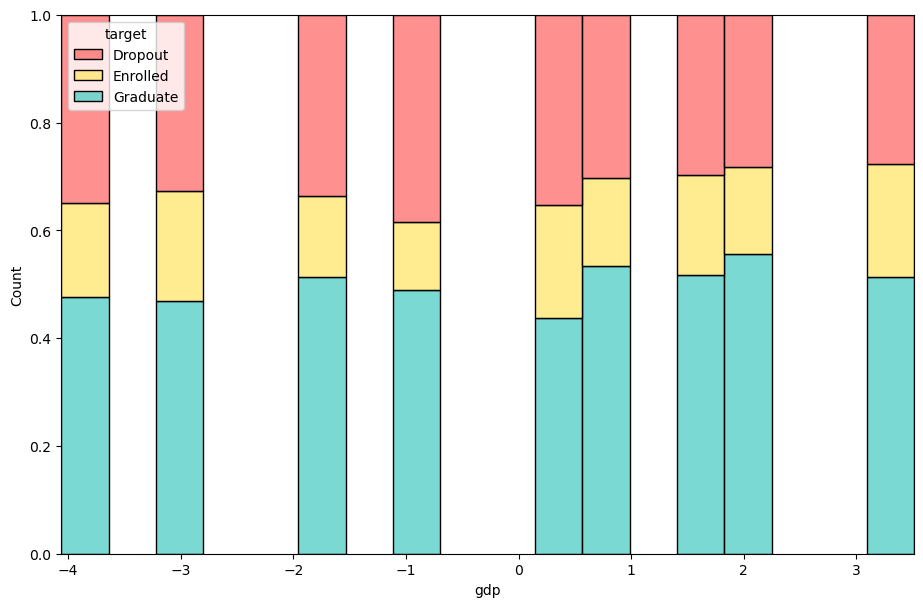

In [28]:
sns.histplot(students, x = "gdp", hue = "target", stat= "count", multiple="fill", palette=target_palette)

<AxesSubplot: xlabel='inflation_rate', ylabel='Count'>

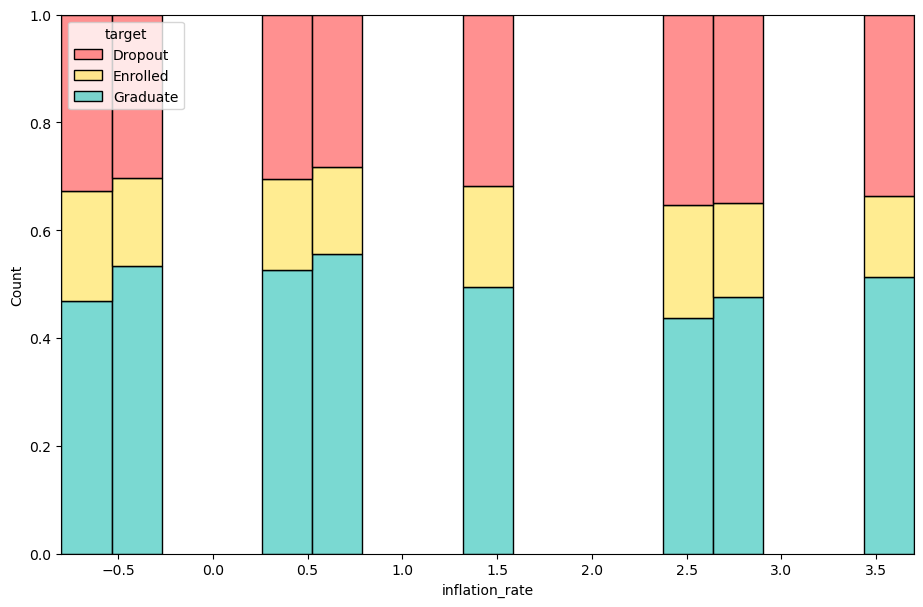

In [29]:
sns.histplot(students, x = "inflation_rate", hue = "target", stat= "count", multiple="fill", palette=target_palette)

# Bivariate analysis

In [8]:
academic_columns = students.columns[students.columns.str.contains("curricular")]
students[academic_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
curricular_units_1st_sem_(credited),4424.0,0.709991,2.360507,0.0,0.00,0.000000,0.000000,20.000000
curricular_units_1st_sem_(enrolled),4424.0,6.270570,2.480178,0.0,5.00,6.000000,7.000000,26.000000
curricular_units_1st_sem_(evaluations),4424.0,8.299051,4.179106,0.0,6.00,8.000000,10.000000,45.000000
curricular_units_1st_sem_(approved),4424.0,4.706600,3.094238,0.0,3.00,5.000000,6.000000,26.000000
curricular_units_1st_sem_(grade),4424.0,10.640822,4.843663,0.0,11.00,12.285714,13.400000,18.875000
curricular_units_1st_sem_(without_evaluations),4424.0,0.137658,0.690880,0.0,0.00,0.000000,0.000000,12.000000
curricular_units_2nd_sem_(credited),4424.0,0.541817,1.918546,0.0,0.00,0.000000,0.000000,19.000000
curricular_units_2nd_sem_(enrolled),4424.0,6.232143,2.195951,0.0,5.00,6.000000,7.000000,23.000000
curricular_units_2nd_sem_(evaluations),4424.0,8.063291,3.947951,0.0,6.00,8.000000,10.000000,33.000000
curricular_units_2nd_sem_(approved),4424.0,4.435805,3.014764,0.0,2.00,5.000000,6.000000,20.000000


In [9]:
first_semester_evals = students[["curricular_units_1st_sem_(evaluations)", "curricular_units_1st_sem_(approved)", "target"]]
first_semester_evals.columns = ["evaluations", "approved", "target"]

In [32]:
all(first_semester_evals.assign(correct = lambda x: x.evaluations >= x.approved)["correct"])
# Checking if the number of evaluations is always greater or equal to the number of approved evaluations, it checks

True

<AxesSubplot: xlabel='evaluations', ylabel='pct_approved'>

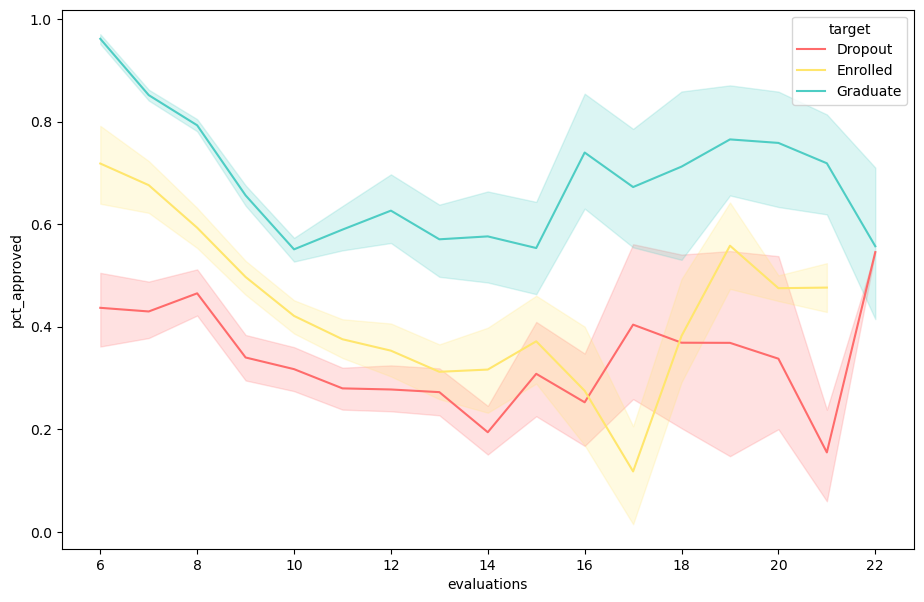

In [33]:
first_semester_evals = first_semester_evals.assign(pct_approved = lambda x: x.approved / x.evaluations).query("evaluations > 5")
sns.lineplot(first_semester_evals.query("evaluations <= 22"), x = "evaluations", y = "pct_approved", hue = "target", palette=target_palette)

This one looks like a really good predictor, there is a clear difference between students who graduate on time and the others, and this is just information from the first semester of the course! Lets check the second semester

<AxesSubplot: xlabel='evaluations', ylabel='pct_approved'>

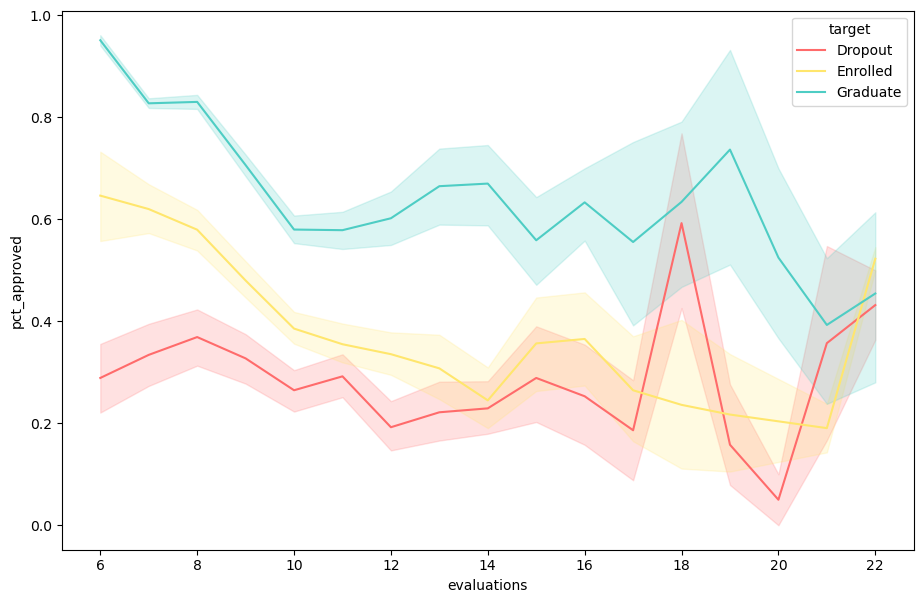

In [34]:
second_semester_evals = students[["curricular_units_2nd_sem_(evaluations)", "curricular_units_2nd_sem_(approved)", "target"]]
second_semester_evals.columns = ["evaluations", "approved", "target"]
second_semester_evals = second_semester_evals.assign(pct_approved = lambda x: x.approved / x.evaluations)\
    .query("evaluations > 5")
sns.lineplot(second_semester_evals.query("evaluations <= 22"), x = "evaluations", y = "pct_approved", hue = "target", palette = target_palette)

Again this is a good predictor. Probably I should do some dimensionality reductions or clustering with these academic data variables, because they seem to be very correlated with the output

## Correlation analysis

In [10]:
students_nums = pd.read_csv("../data/students_processed.csv")
le = LabelEncoder()
students_nums["target"] = le.fit_transform(students_nums["target"])

In [36]:
le.classes_

array(['Dropout', 'Enrolled', 'Graduate'], dtype=object)

<AxesSubplot: >

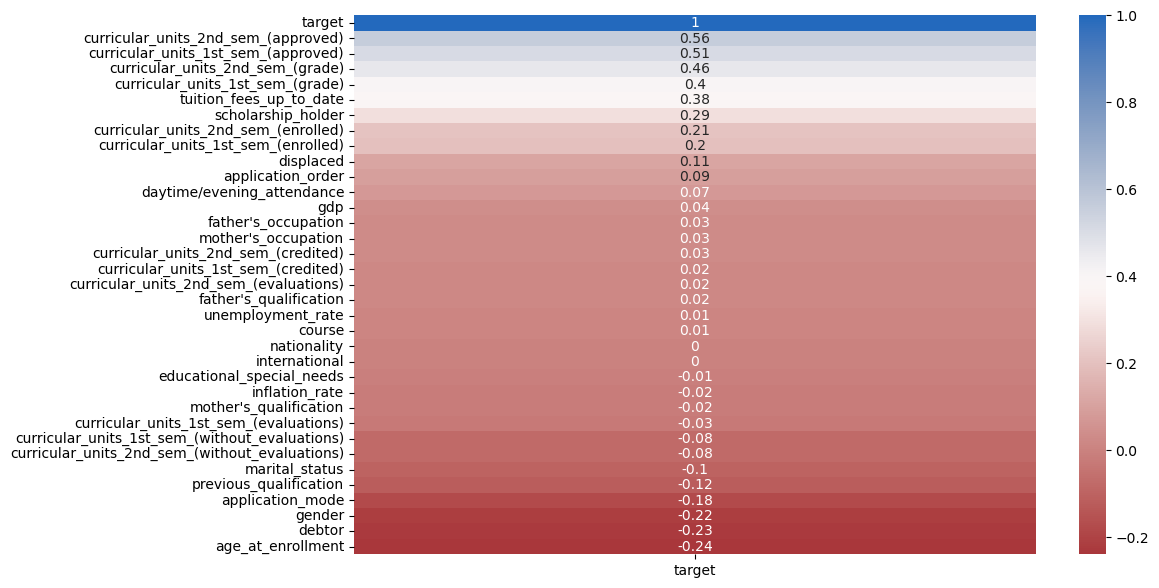

In [37]:
corr_mat = students_nums.corr(method = "kendall").round(2)
sns.heatmap(corr_mat[["target"]].sort_values("target", ascending = False), cmap = "vlag_r", annot = True)

<AxesSubplot: >

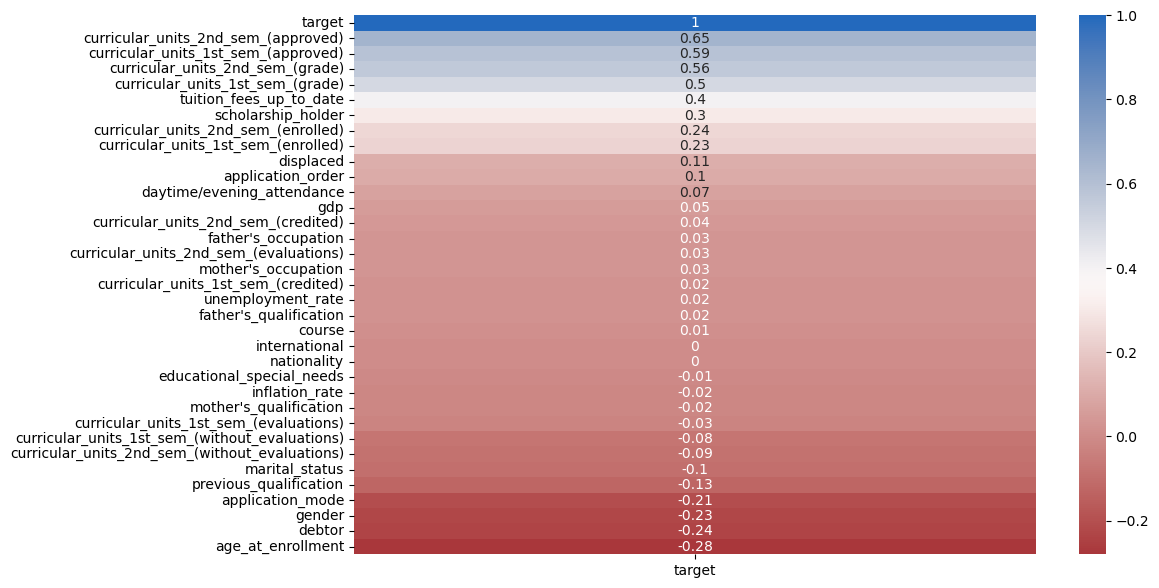

In [38]:
corr_mat = students_nums.corr(method = "spearman").round(2)
sns.heatmap(corr_mat[["target"]].sort_values("target", ascending = False), cmap = "vlag_r", annot = True)

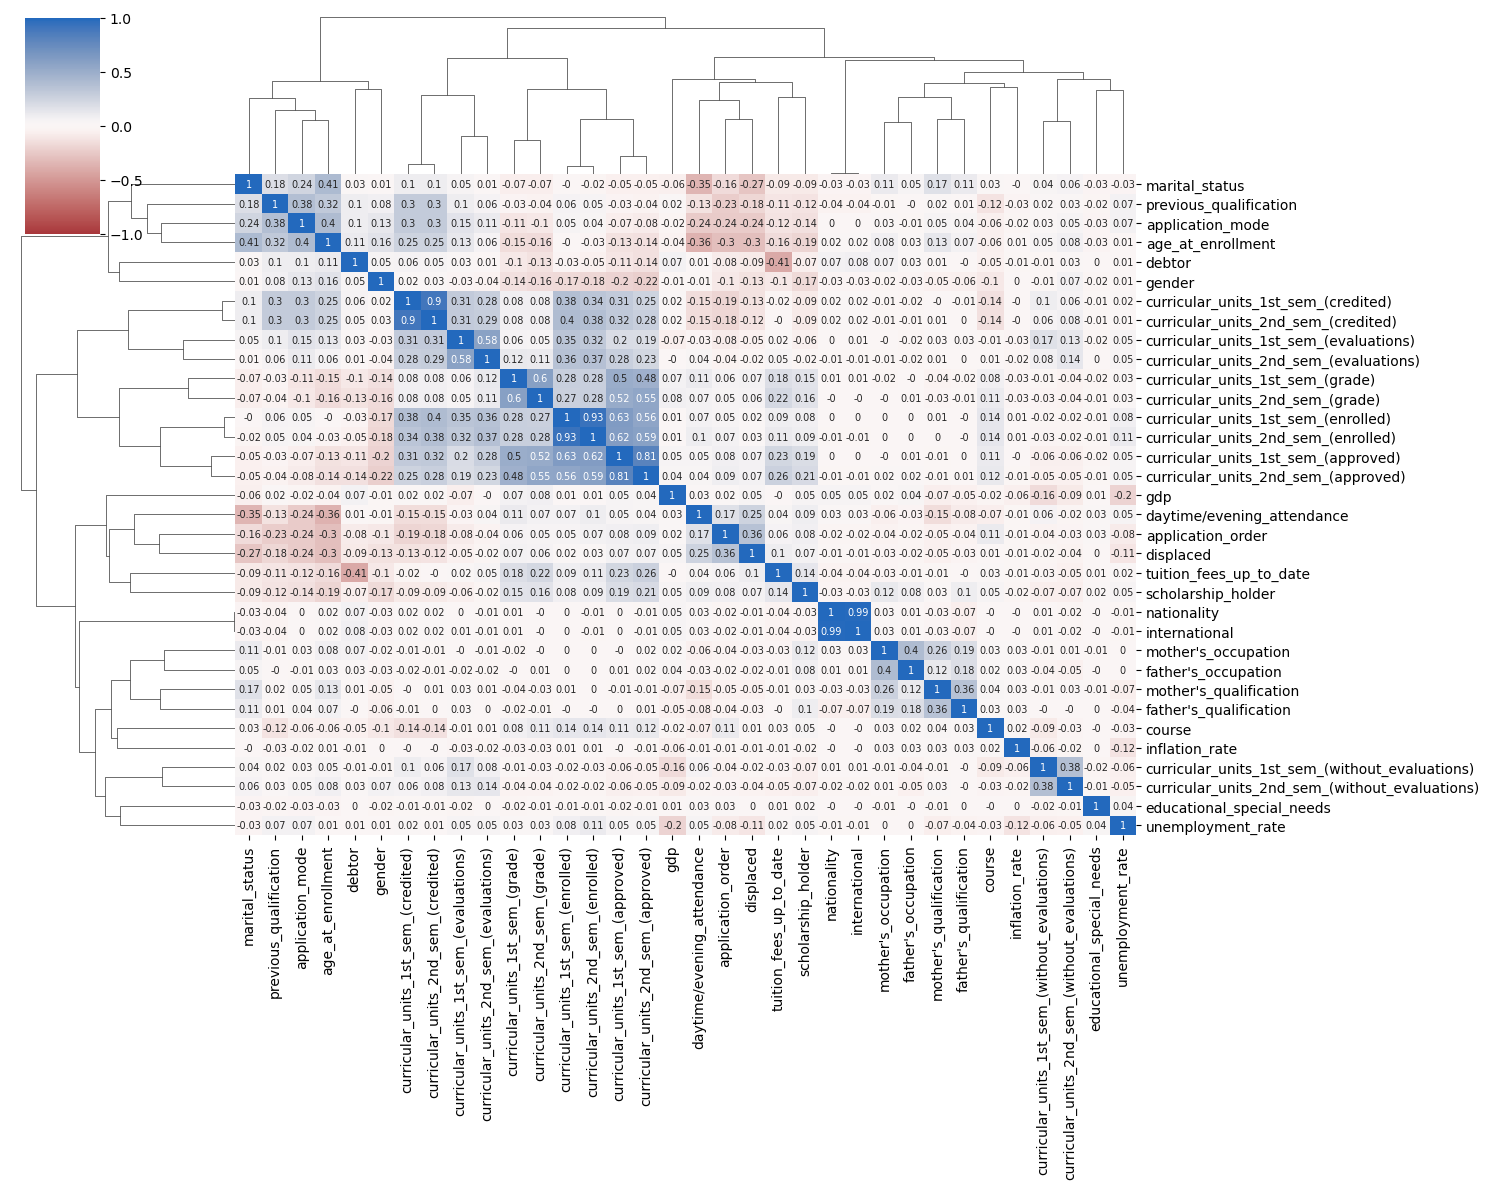

In [39]:
g = sns.clustermap(students_nums.drop(columns = "target").corr(method = "kendall").round(2), method="complete", cmap='vlag_r', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));

Looks like there are some clusters in our data, the biggest one being the academic data variables. I will try to make a umap transformation on these variables and see how do they relate to the target

## UMAP on academic data

As seen above, the academic variables are highly skewed and with a lot of zeroes and outliers, that's why I will use the robust scaler before performing the dimensionality reduction.

This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results.

In [11]:
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from umap import UMAP

In [76]:
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

students_academic = students[academic_columns].copy()

students_academic_robust_sc = robust_scaler.fit_transform(students_academic)
students_academic_standard_sc = standard_scaler.fit_transform(students_academic)

target_encoder = LabelEncoder()
target_enc = target_encoder.fit_transform(students["target"])

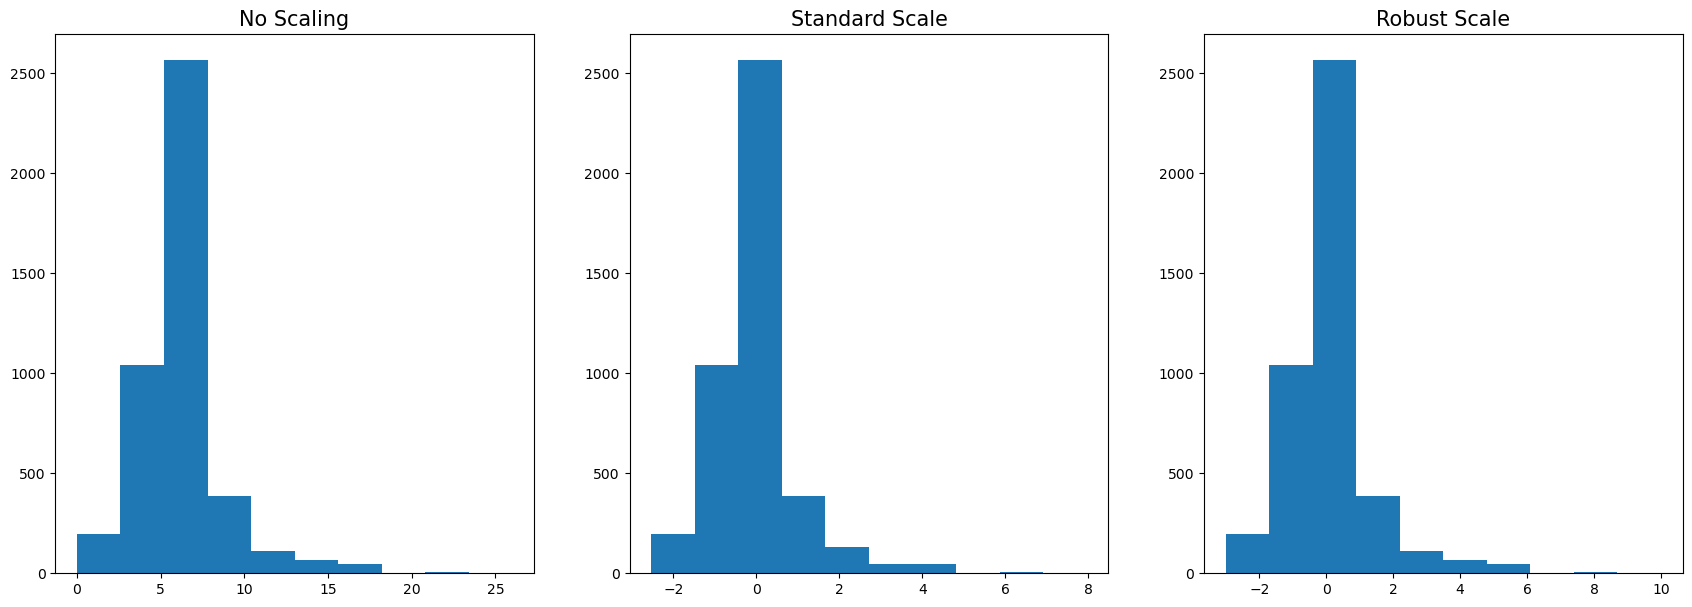

In [82]:
column_number = 1

fig, ax = plt.subplots(1, 3, figsize = (21, 7))
ax[0].hist(students_academic.iloc[:,column_number])
ax[0].set_title("No Scaling", fontsize = 15)
ax[1].hist(students_academic_standard_sc[:,column_number])
ax[1].set_title("Standard Scale", fontsize = 15)
ax[2].hist(students_academic_robust_sc[:,column_number])
ax[2].set_title("Robust Scale", fontsize = 15)
plt.show()

In [85]:
for col in range(students_academic_robust_sc.shape[1]):
    print(f"The mean of the {students_academic.columns[col]} column is {students_academic_robust_sc[:,col].mean()}; sd = {students_academic_robust_sc[:,col].std()} ")

The mean of the curricular_units_1st_sem_(credited) column is 0.7099909584086799; sd = 2.3602398198385526 
The mean of the curricular_units_1st_sem_(enrolled) column is 0.13528481012658228; sd = 1.2399489249984093 
The mean of the curricular_units_1st_sem_(evaluations) column is 0.0747626582278481; sd = 1.0446583050980325 
The mean of the curricular_units_1st_sem_(approved) column is -0.09779987944544909; sd = 1.0312960831629603 
The mean of the curricular_units_1st_sem_(grade) column is -0.6853719627333752; sd = 2.0179649664230452 
The mean of the curricular_units_1st_sem_(without_evaluations) column is 0.13765822784810128; sd = 0.6908020961134163 
The mean of the curricular_units_2nd_sem_(credited) column is 0.5418173598553345; sd = 1.9183292975785422 
The mean of the curricular_units_2nd_sem_(enrolled) column is 0.11607142857142858; sd = 1.0978512756605001 
The mean of the curricular_units_2nd_sem_(evaluations) column is 0.015822784810126583; sd = 0.986876179808235 
The mean of the 

In [87]:
for col in range(students_academic.shape[1]):
    print(f"The mean of the {students_academic.columns[col]} column is {students_academic.iloc[:,col].mean()}; sd = {students_academic.iloc[:,col].std()} ")

The mean of the curricular_units_1st_sem_(credited) column is 0.7099909584086799; sd = 2.3605066191181976 
The mean of the curricular_units_1st_sem_(enrolled) column is 6.2705696202531644; sd = 2.480178175307158 
The mean of the curricular_units_1st_sem_(evaluations) column is 8.299050632911392; sd = 4.179105569144036 
The mean of the curricular_units_1st_sem_(approved) column is 4.706600361663653; sd = 3.094237979693975 
The mean of the curricular_units_1st_sem_(grade) column is 10.640821575154185; sd = 4.843663380663813 
The mean of the curricular_units_1st_sem_(without_evaluations) column is 0.13765822784810128; sd = 0.6908801837297979 
The mean of the curricular_units_2nd_sem_(credited) column is 0.5418173598553345; sd = 1.9185461437101994 
The mean of the curricular_units_2nd_sem_(enrolled) column is 6.232142857142857; sd = 2.1959507514632417 
The mean of the curricular_units_2nd_sem_(evaluations) column is 8.063291139240507; sd = 3.94795094143741 
The mean of the curricular_units

In [89]:
embedding = UMAP().fit_transform(students_academic_robust_sc, target_enc)

<AxesSubplot: >

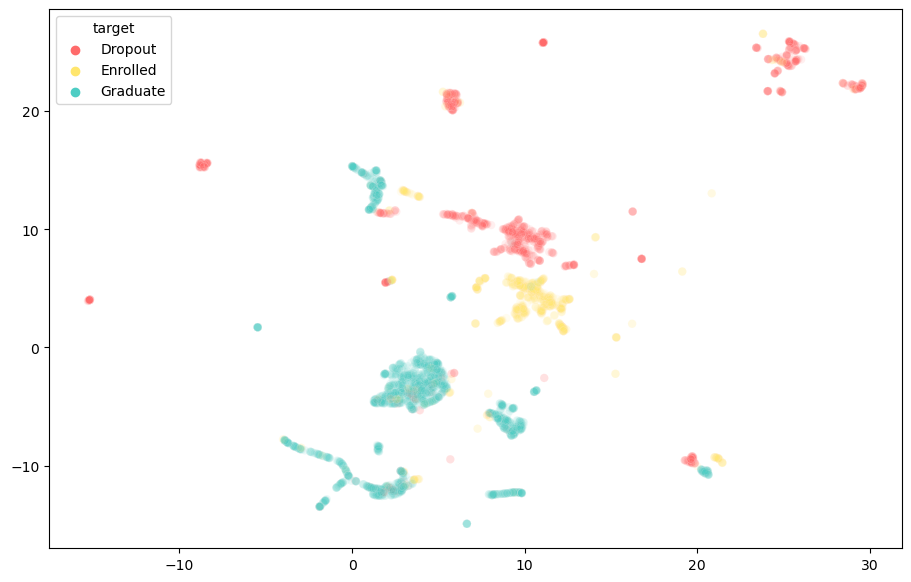

In [93]:
sns.scatterplot(x = embedding[:,0], y = embedding[:,1], hue = students["target"], palette = target_palette, alpha = 0.1)

## PCA on academic data

In [94]:
# PCA Analysis

from sklearn.decomposition import PCA

pca = PCA()
pca_rs = pca.fit_transform(students_academic_robust_sc)
pca_df = pd.DataFrame(pca_rs, columns = [f"PC{i + 1}" for i in range(pca_rs.shape[1])])

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

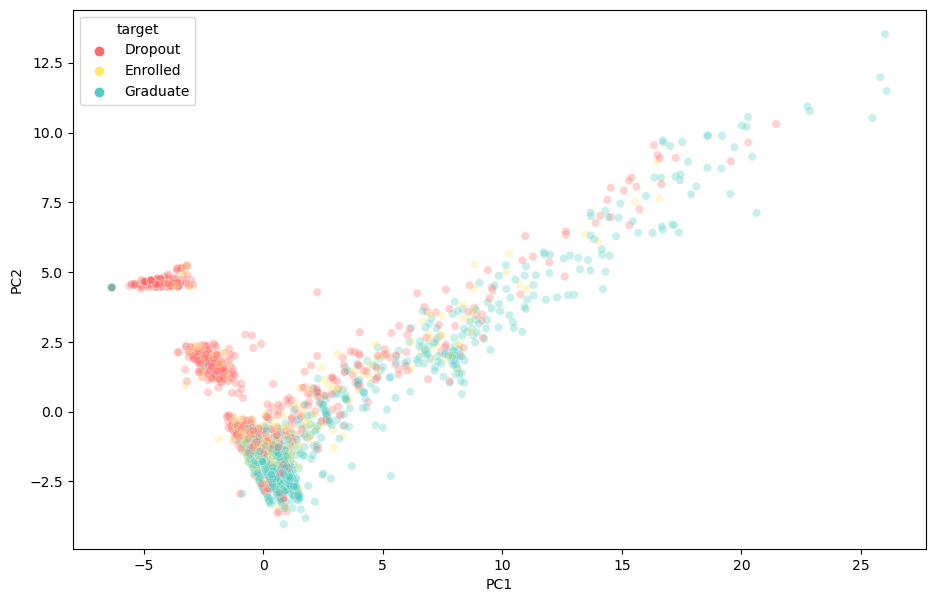

In [95]:
sns.scatterplot(x = pca_df["PC1"], y = pca_df["PC2"], hue = students["target"], palette = target_palette, alpha = 0.3)

We can see a that PCA does a worst job at dividing the categories than UMAP. UMAP has the advantage of using the target to do supervised dimensionality reduction.

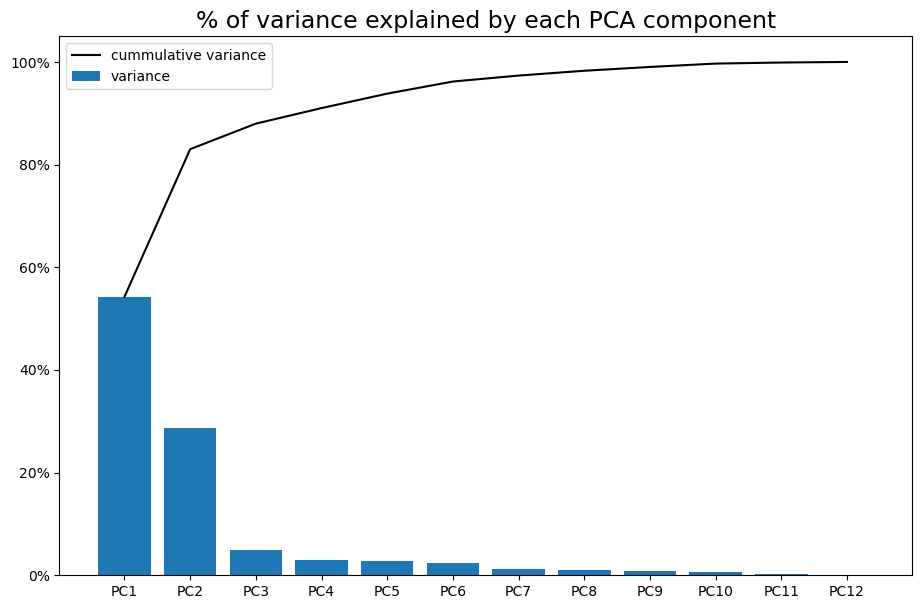

In [96]:
plt.bar(x = range(pca_rs.shape[1]), height= pca.explained_variance_ratio_)
plt.plot(range(pca_rs.shape[1]), pca.explained_variance_ratio_.cumsum(), c = "black")
plt.legend(["cummulative variance", "variance"])
plt.xticks(ticks = range(pca_rs.shape[1]), labels = [f"PC{i + 1}" for i in range(pca_rs.shape[1])])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("% of variance explained by each PCA component", fontsize = 17)
plt.show()

In [97]:
pca_comps = pd.DataFrame(pca.components_, index = pca_df.columns, columns = academic_columns).reset_index(names = "component")

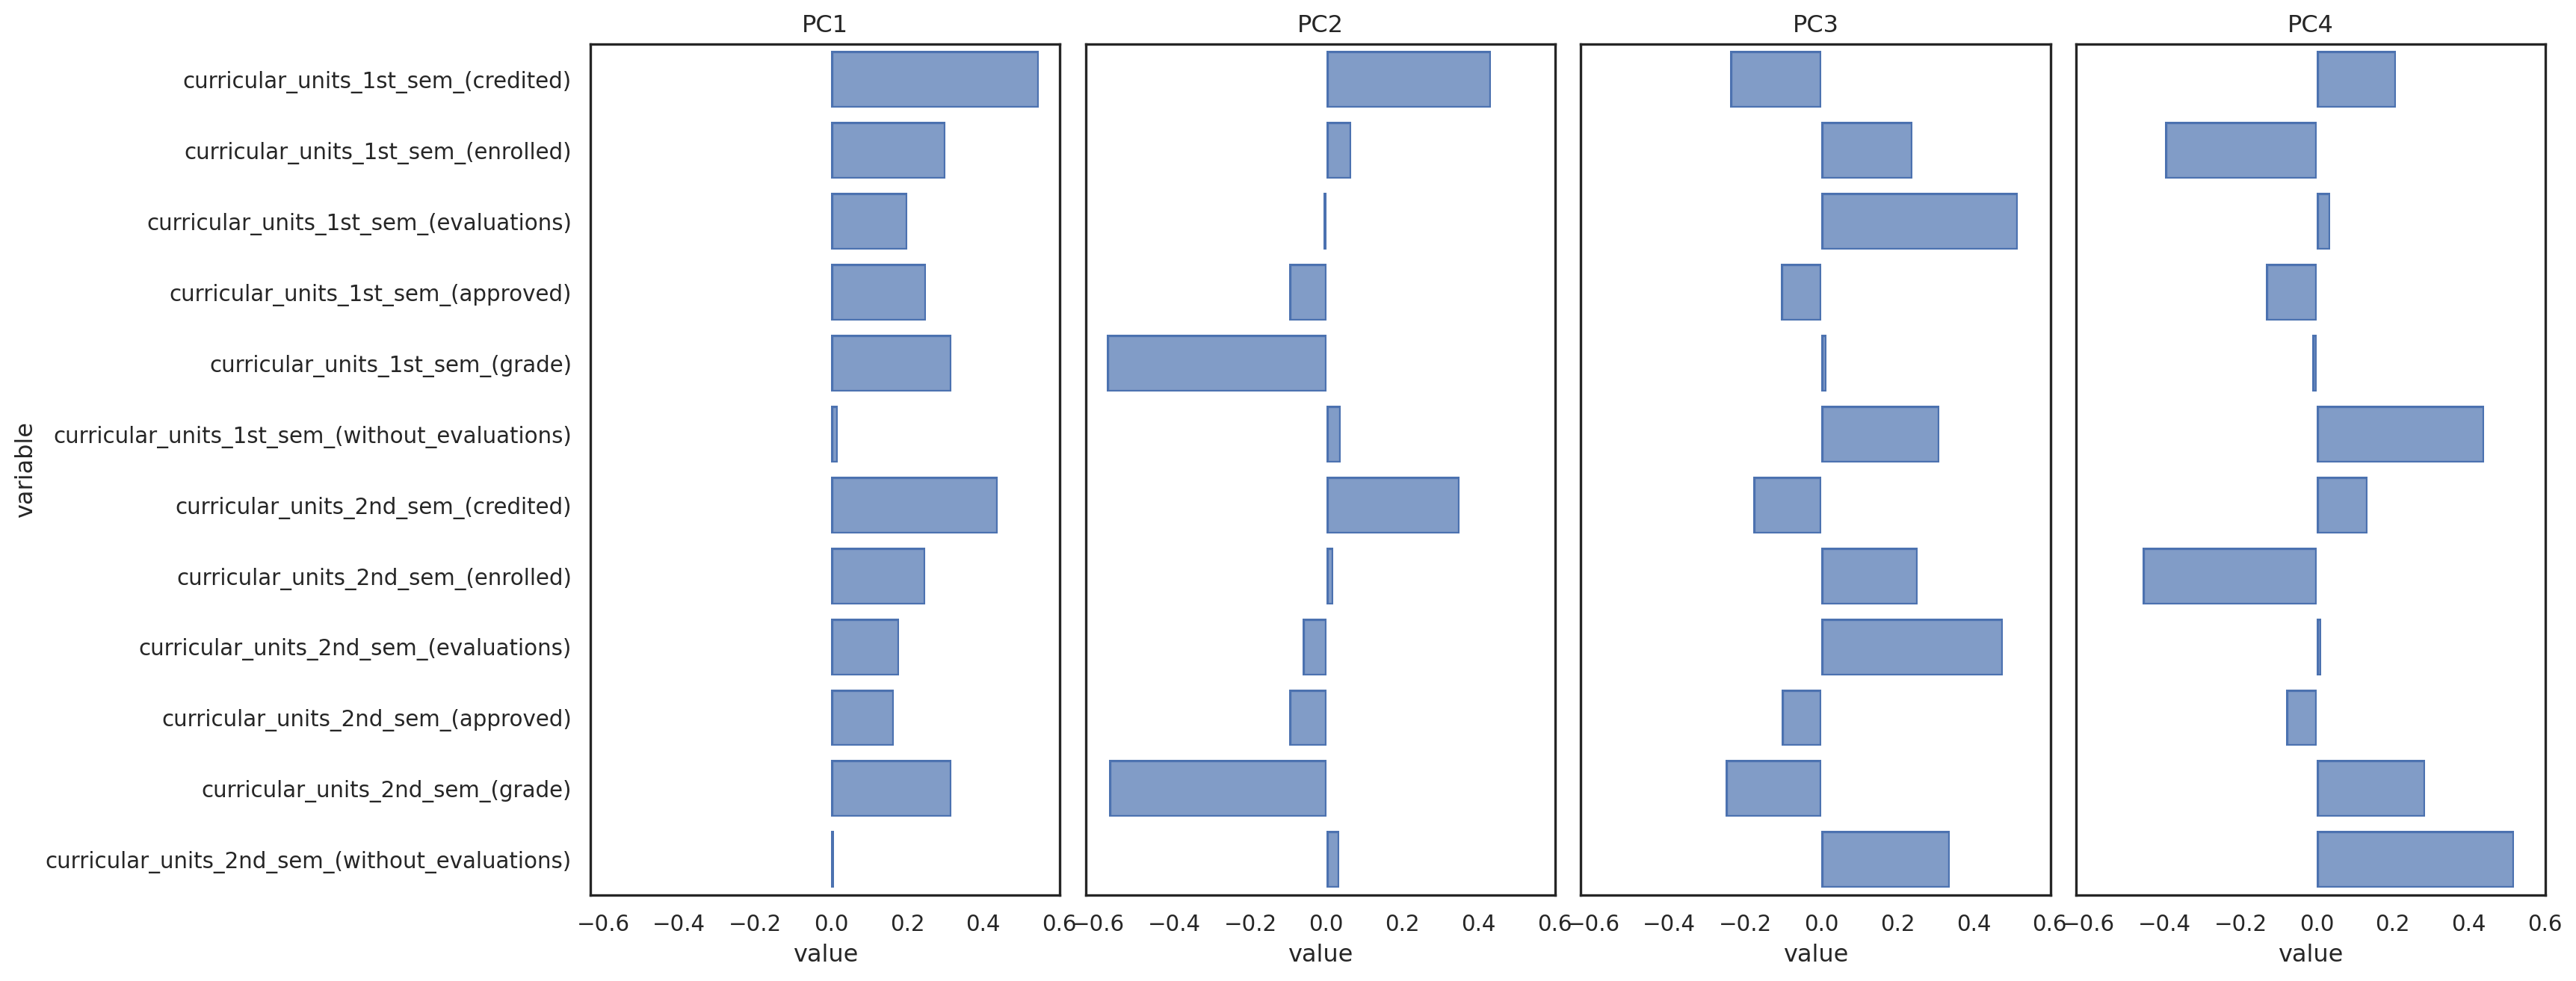

In [98]:
pca_comps_long = pca_comps.melt(id_vars = "component").query("component.isin(['PC1','PC2','PC3','PC4'])")

(
    so.Plot(pca_comps_long, "value", "variable")
    .add(so.Bar())
    .facet("component", wrap = 4)
    .layout(size = (18,7))
    .theme({**axes_style("white")})
)

Higher credited and lower grade means dropout?? CHECK

Most of the variance in the PCA analysis is explained by the first 3 components. I will try to extend the UMAP analysis to 3 components also to see if there is and improvement on the division of the categories

<AxesSubplot: xlabel='curricular_units_1st_sem_(credited)', ylabel='curricular_units_2nd_sem_(credited)'>

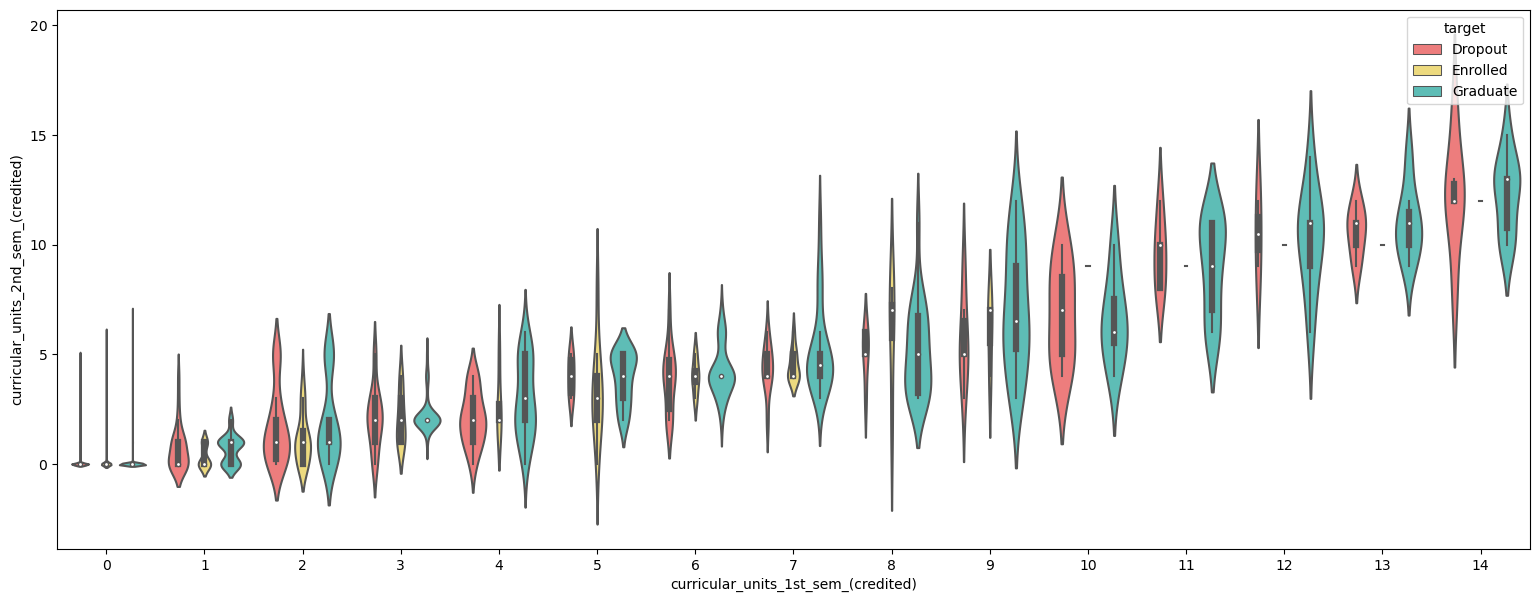

In [24]:
plt.figure(figsize = (19,7))
sns.violinplot(students[students["curricular_units_1st_sem_(credited)"] < 15], x = "curricular_units_1st_sem_(credited)", y = "curricular_units_2nd_sem_(credited)", hue = "target",
            palette=target_palette, scale = "count")

In [100]:
embedding_3d = UMAP(n_components=3, n_neighbors=10).fit_transform(students_academic_robust_sc, target_enc)
embedding_3d_df = pd.DataFrame(embedding_3d, columns = [f"UMAP{i}" for i in range(1,4)])

In [103]:
fig = px.scatter_3d(embedding_3d_df, x='UMAP1', y='UMAP2', z='UMAP3',color=students["target"],
                    title="Students academic variables - UMAP", height = 800, width = 1100,
                    color_discrete_map=target_palette,
                    opacity = 0.2)
fig.show()

From the visual analysis, the 3 components UMAP is doing better than the 2 components UMAP to discriminate the different categories. If I will use this as a preprocessing step in the classification model, I will have to tune this hyperparameter

# Questions

1.  Why is there a difference between men and women in dropouts?

In [108]:
import statsmodels.formula.api as smf
students_dropout = students.copy()
students_dropout["target"] = np.where(students["target"] == "Dropout", 1, 0)

In [109]:
students_dropout.target.value_counts()

0    3003
1    1421
Name: target, dtype: int64

In [124]:
students_dropout.groupby("gender").target.value_counts(normalize=True)

gender  target
female  0         0.748954
        1         0.251046
male    0         0.549486
        1         0.450514
Name: target, dtype: float64

In [127]:
2.4459 / 3.4459

0.7098000522359906

In [128]:
model = smf.logit("target ~ gender", students_dropout).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.607362
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 4424
Model:                          Logit   Df Residuals:                     4422
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Jan 2023   Pseudo R-squ.:                 0.03251
Time:                        23:37:11   Log-Likelihood:                -2687.0
converged:                       True   LL-Null:                       -2777.3
Covariance Type:            nonrobust   LLR p-value:                 3.593e-41
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0930      0.043    -25.382      0.000      -1.177      -1.009
gender[T.male]     0.8944      0.067     13.407      0.000       0.764       1.025
==================================================================================
"""

In [129]:
params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                      5%       95%  Odds Ratio
Intercept       0.308065  0.364715    0.335196
gender[T.male]  2.146189  2.787658    2.445984


In [132]:
model = smf.logit("target ~ gender + course", students_dropout).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.582247
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 4424
Model:                          Logit   Df Residuals:                     4406
Method:                           MLE   Df Model:                           17
Date:                Wed, 11 Jan 2023   Pseudo R-squ.:                 0.07252
Time:                        23:40:02   Log-Likelihood:                -2575.9
converged:                       True   LL-Null:                       -2777.3
Covariance Type:            nonrobust   LLR p-value:                 4.784e-75
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -0.9570      0.135     -7.076      0.000      -1.222      -0.692
gender[T.male]                                    0.7427      0.075      9.860      0.000       0.595       0.890
course[T.Agronomy]                                0.0513      0.193      0.265      0.791      -0.328       0.430
course[T.Animation and Multimedia Design]         0.0522      0.193      0.271      0.787      -0.326       0.430
course[T.Basic Education]                         0.6920      0.198      3.491      0.000       0.304       1.080
course[T.Biofuel Production Technologies]         1.1081      0.634      1.748      0.080      -0.134       2.350
course[T.Communication Design]                   -0.6283      0.207     -3.038      0.002      -1.034      -0.223
course[T.Equiniculture]                           0.8523      0.216      3.951      0.000       0.429       1.275
course[T.Informatics Engineering]                 0.4097      0.204      2.003      0.045       0.009       0.810
course[T.Journalism and Communication]           -0.1471      0.178     -0.828      0.408      -0.495       0.201
course[T.Management]                              0.0138      0.169      0.081      0.935      -0.318       0.346
course[T.Management (evening attendance)]         0.6109      0.180      3.400      0.001       0.259       0.963
course[T.Nursing]                                -0.9216      0.165     -5.579      0.000      -1.245      -0.598
course[T.Oral Hygiene]                            0.3110      0.260      1.196      0.232      -0.199       0.821
course[T.Social Service]                         -0.6546      0.191     -3.426      0.001      -1.029      -0.280
course[T.Social Service (evening attendance)]     0.0925      0.197      0.470      0.639      -0.293       0.478
course[T.Tourism]                                 0.1624      0.185      0.878      0.380      -0.200       0.525
course[T.Veterinary Nursing]                     -0.2021      0.181     -1.117      0.264      -0.557       0.153
=================================================================================================================
"""

In [113]:
params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                                                     5%        95%  Odds Ratio
Intercept                                      0.294626   0.500609    0.384048
gender[T.male]                                 1.813090   2.435803    2.101506
course[T.Agronomy]                             0.720703   1.537379    1.052612
course[T.Animation and Multimedia Design]      0.721913   1.537735    1.053618
course[T.Basic Education]                      1.354604   2.945878    1.997623
course[T.Biofuel Production Technologies]      0.874492  10.487891    3.028462
course[T.Communication Design]                 0.355701   0.800155    0.533494
course[T.Equiniculture]                        1.536485   3.578969    2.345002
course[T.Informatics Engineering]              1.008930   2.248907    1.506317
course[T.Journalism and Communication]         0.609461   1.222639    0.863221
course[T.Management]                           0.727296   1.413386    1.013879
course[T.Management (evening attendance)]      1.295

In [134]:
model = smf.logit("target ~ gender + course + age_at_enrollment + debtor + marital_status", students_dropout).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.542542
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 4424
Model:                          Logit   Df Residuals:                     4399
Method:                           MLE   Df Model:                           24
Date:                Wed, 11 Jan 2023   Pseudo R-squ.:                  0.1358
Time:                        23:40:35   Log-Likelihood:                -2400.2
converged:                       True   LL-Null:                       -2777.3
Covariance Type:            nonrobust   LLR p-value:                9.952e-144
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -3.1013      0.356     -8.710      0.000      -3.799      -2.403
gender[T.male]                                    0.6542      0.079      8.244      0.000       0.499       0.810
course[T.Agronomy]                               -0.4450      0.207     -2.154      0.031      -0.850      -0.040
course[T.Animation and Multimedia Design]         0.1778      0.201      0.887      0.375      -0.215       0.571
course[T.Basic Education]                         0.7103      0.207      3.430      0.001       0.304       1.116
course[T.Biofuel Production Technologies]         0.3956      0.688      0.575      0.565      -0.953       1.745
course[T.Communication Design]                   -0.5467      0.216     -2.536      0.011      -0.969      -0.124
course[T.Equiniculture]                           0.8027      0.226      3.559      0.000       0.361       1.245
course[T.Informatics Engineering]                 0.3230      0.215      1.505      0.132      -0.098       0.744
course[T.Journalism and Communication]           -0.0797      0.186     -0.428      0.669      -0.445       0.285
course[T.Management]                             -0.0280      0.178     -0.157      0.875      -0.377       0.321
course[T.Management (evening attendance)]         0.0323      0.197      0.164      0.870      -0.354       0.419
course[T.Nursing]                                -0.7921      0.172     -4.607      0.000      -1.129      -0.455
course[T.Oral Hygiene]                            0.1607      0.275      0.584      0.559      -0.379       0.700
course[T.Social Service]                         -0.7158      0.200     -3.571      0.000      -1.109      -0.323
course[T.Social Service (evening attendance)]    -0.7601      0.222     -3.428      0.001      -1.195      -0.326
course[T.Tourism]                                 0.1962      0.193      1.014      0.310      -0.183       0.575
course[T.Veterinary Nursing]                     -0.1901      0.189     -1.003      0.316      -0.561       0.181
debtor[T.yes]                                     1.2977      0.106     12.201      0.000       1.089       1.506
marital_status[T.Facto union]                     0.1045      0.509      0.206      0.837      -0.892       1.101
marital_status[T.Legally separated]               1.2453      0.998      1.248      0.212      -0.710       3.201
marital_status[T.Married]                        -0.0510      0.258     -0.198      0.843      -0.556       0.454
marital_status[T.Single]                          0.3396      0.255      1.329      0.184      -0.161       0.840
marital_status[T.Widower]                        -1.2606      1.351     -0.933      0.351      -3.909       1.388
age_at_enrollment                                 0.0762      0.007     11.331      0.000       0.063       0.089
=================================================